# Polarity in C. elegans via PAR proteins 

### Group 1:
#### Members: 

This project is done to explain Anterrior Posterior Symmetry Breaking in C.elegans embroys by the interplay of PAR complexes and cortical flow:

In [1]:
import sys
import os
sys.path.append('ExperimentalData/')

import numpy as np
import scipy as sc
import pickle
import dill
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
dill.dump_session('data/projectPolarity')

In [3]:
dill.load_session('data/projectPolarity')

### Experimental Data

In [4]:
with open('ExperimentalData/T_PARs.txt','r') as T_PARs:
    time_pars = np.loadtxt(T_PARs)
T_PARs.close()
    
with open('ExperimentalData/X_PARs.txt','r') as X_PARs:
    x_pars = np.loadtxt(X_PARs)
X_PARs.close()

with open('ExperimentalData/PAR6.txt','r') as A_PARs:
    a_pars = np.loadtxt(A_PARs)
A_PARs.close()

with open('ExperimentalData/PAR2.txt','r') as P_PARs:
    p_pars = np.loadtxt(P_PARs)
P_PARs.close()

with open('ExperimentalData/X_flow.txt','r') as X_flow:
    x_flow = np.loadtxt(X_flow)
X_flow.close()
    
with open('ExperimentalData/T_flow.txt','r') as T_flow:
    t_flow = np.loadtxt(T_flow)
T_flow.close()

with open('ExperimentalData/Flow.txt','r') as F_flow:
    f_flow = np.loadtxt(F_flow)
F_flow.close()

#with open("FLOW_INTERP_4077.mat",'r') as int_flow:
    #interp_flow = np.load(int_flow)

from scipy.io import loadmat
interp_mat = loadmat("FLOW_INTERP_4077.mat")['FF_interp']

In [5]:
V_cyto = 2.5*10**4
S_mem = 4.4*10**3
D_a = 0.28
D_p = 0.15
k_offa = 3.24*10**-3
k_offp = 7.19*10**-3
k_ona = 6.29*10**-3
k_onp = 7.682*10**-2
alpha = 2.
beta = 2.
N_a = 2.4*10**5
N_p = 9.8*10**4

### Plotting Experimental data

Text(0.5,1,u'P_PAR')

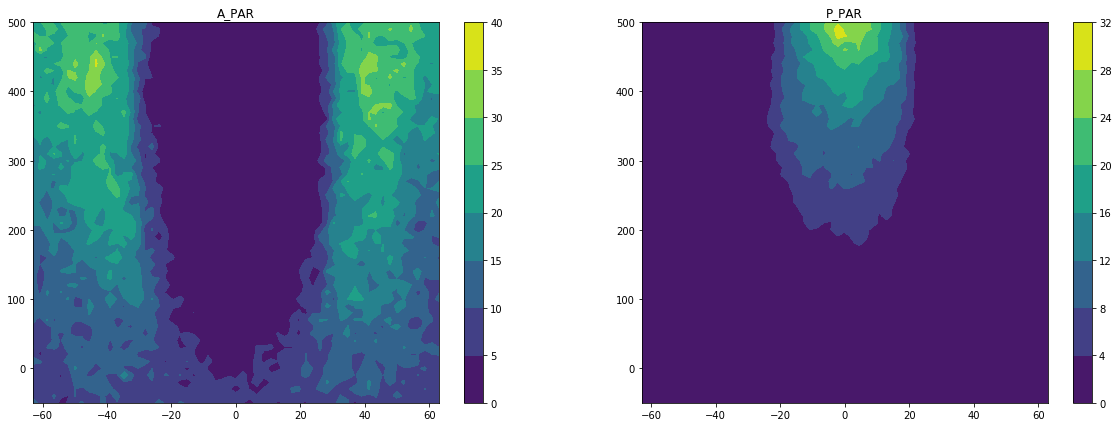

In [6]:
plt.figure(figsize=(20,7))
plt.subplot(121)
plt.contourf(x_pars,time_pars,a_pars)
plt.colorbar()
plt.title('A_PAR')

plt.subplot(122)
plt.contourf(x_pars,time_pars,p_pars)
plt.colorbar()
plt.title('P_PAR')

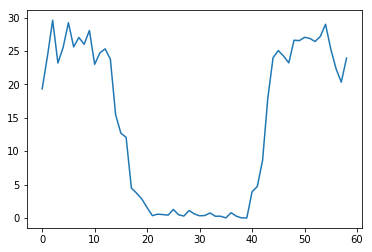

In [7]:
plt.plot(a_pars[-1,:])

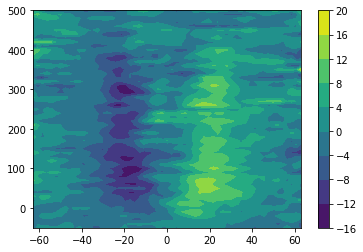

In [9]:
plt.contourf(x_flow,t_flow,f_flow)
plt.colorbar()

In [10]:
a_pars_cyto = (np.ones(np.shape(a_pars))*N_a - a_pars*S_mem)/V_cyto
p_pars_cyto = (np.ones(np.shape(p_pars))*N_p - p_pars*S_mem)/V_cyto

a_pars_pm_total = np.sum(a_pars,axis=1)*S_mem
p_pars_pm_total = np.sum(p_pars,axis=1)*S_mem
a_pars_cyto_total = np.sum(a_pars_cyto,axis=1)*V_cyto
p_pars_cyto_total = np.sum(p_pars_cyto,axis=1)*V_cyto

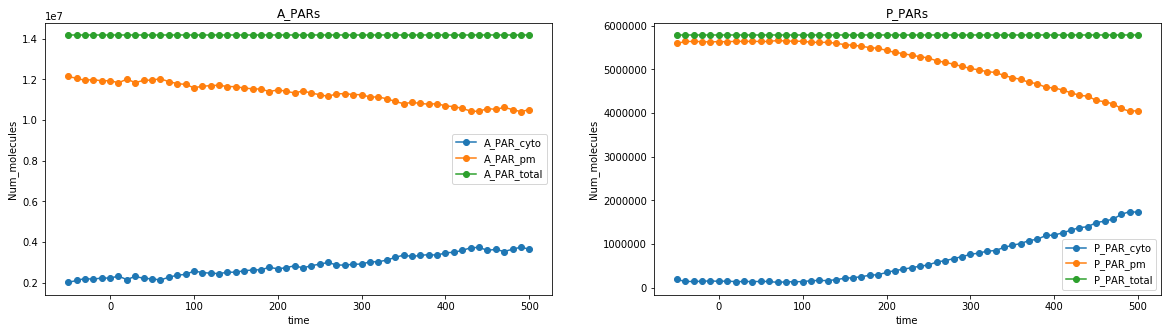

In [11]:
plt.figure(figsize=(20,5))

plt.subplot(121)
plt.plot(time_pars,a_pars_pm_total,'o-')
plt.plot(time_pars,a_pars_cyto_total,'o-')
plt.plot(time_pars,a_pars_pm_total+a_pars_cyto_total,'o-')
plt.title('A_PARs')
plt.ylabel('Num_molecules')
plt.xlabel('time')
plt.legend(['A_PAR_cyto','A_PAR_pm','A_PAR_total'])

plt.subplot(122)
plt.plot(time_pars,p_pars_pm_total,'o-')
plt.plot(time_pars,p_pars_cyto_total,'o-')
plt.plot(time_pars,p_pars_pm_total+p_pars_cyto_total,'o-')
plt.title('P_PARs')
plt.ylabel('Num_molecules')
plt.xlabel('time')
plt.legend(['P_PAR_cyto','P_PAR_pm','P_PAR_total'])

## System of equations:

$$ \frac{\partial A(x,t)}{\partial t} = -k_{offA}'A - K_{AP}A(x,t)P^{\alpha}(x,t) + {k_{onA}N_A/V_{cyto}} + D_A\frac{\partial^2 A(x,t)}{\partial x^2} - \frac{\partial}{\partial x} \left( A(x,t)v(x,t) \right)$$

$$ \frac{\partial P(x,t)}{\partial t} = -k_{offP}'P - K_{PA}P(x,t)A^{\beta}(x,t) + {k_{onP}N_P/V_{cyto}} + D_P\frac{\partial^2 P(x,t)}{\partial x^2} - \frac{\partial}{\partial x}\left(P(x,t)v(x,t)\right) $$

where $$ k_{offA}' = k_{offA} + \frac{k_{onA}\omega_{membrane}}{V_{cyto}} $$

$$ k_{offP}' = k_{offP} + \frac{k_{onP}\omega_{membrane}}{V_{cyto}} $$


### The system:

In [61]:
## Determining the time step:

t_delta = abs(np.round(0.5*2*((x_pars - np.roll(x_pars,1))[1])/(np.max(abs(f_flow))),10))
x_delta = (x_pars - np.roll(x_pars,1))[1]

total_pos = len(x_pars)
int_time  = np.int(np.ceil((time_pars[-1]-time_pars[0])/t_delta))

#Parameters:
par = [k_offa + k_ona*S_mem/V_cyto, k_offp + k_onp*S_mem/V_cyto, k_ona*N_a/V_cyto, k_onp*N_p/V_cyto, 2,2, D_a,D_p]

#Initial Conditions:
x0 = np.zeros([2,len(x_pars)])
#x0[0,:] = a_pars[0,:]
#x0[1,:] = p_pars[0,:]

x0[0,10:20] = 1.
x0[1,30:40] = 1.

# Interploating velocities:

v_interp = np.zeros([int_time,len(x_pars)])
for i in np.arange(len(x_pars)):
    interp_fun = sc.interpolate.interp1d(time_pars,f_flow[:,i],kind=5)
    v_interp[:,i] = interp_fun(np.arange(time_pars[0],time_pars[-1],int_time))
    del interp_fun

In [14]:
def diff(t_delta,x_delta,init_time,total_pos,D_A):
    
    A = np.zeros([total_pos,int_time])
    A[10:20,0] = 1
    
    for i in np.arange(int_time-1):

        A[:,i+1] = A[:,i] + t_delta*(D_A*(np.roll(A[:,i],-1) - 2*A[:,i] + np.roll(A[:,i],1))/(2*x_delta**2))
        
    return A

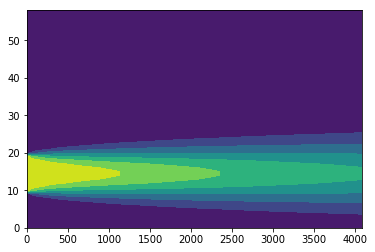

In [15]:
a = diff(t_delta,x_delta,int_time,total_pos,D_a)

plt.contourf(a)

In [308]:
def systemsolve(x0,v,t_delta,x_delta,total_pos,int_time,parametrs):
    
    k_offA = parametrs[0]
    k_offP = parametrs[1]
    c1     = parametrs[2]
    c2     = parametrs[3]
    alpha  = parametrs[4]
    beta   = parametrs[5]
    D_A    = parametrs[6]
    D_P    = parametrs[7]
    
    
    def fitsolver(x,*p):
        
        A = np.zeros([total_pos,int_time])
        A[:,0] = x0[0,:]
        P = np.zeros([total_pos,int_time])
        P[:,0] = x0[1,:]

        K_AP   = p[0]
        K_PA   = p[1]

        for i in np.arange(int_time-1):

            A[:,i+1] = A[:,i] + t_delta*(-k_offA*A[:,i] - K_AP*A[:,i]*P[:,i]**alpha + c1 - \
                       A[:,i]*(np.roll(v[:,i],-1) - np.roll(v[:,i],1))/(2*x_delta) - \
                       v[:,i]*(np.roll(A[:,i],-1) - np.roll(A[:,i],1))/(2*(x_delta)) + \
                       D_A*(np.roll(A[:,i],-1) - 2*A[:,i] + np.roll(A[:,i],1))/(2*x_delta**2))

            P[:,i+1] = P[:,i] + t_delta*(-k_offP*P[:,i] - K_PA*P[:,i]*A[:,i]**beta + c2 - \
                       P[:,i]*(np.roll(v[:,i],-1) - np.roll(v[:,i],1))/(2*x_delta) - \
                       v[:,i]*(np.roll(P[:,i],-1) - np.roll(P[:,i],1))/(2*(x_delta)) + \
                       D_P*(np.roll(P[:,i],-1) - 2*P[:,i] + np.roll(P[:,i],1))/(2*x_delta**2))
            
        total = np.zeros(2*len(x))

        total[0:len(x)] = np.interp(x,np.arange(x[0],x[-1],t_delta),np.sum(A,axis=0))            

        total[len(x)-1:-1] = np.interp(x,np.arange(x[0],x[-1],t_delta),np.sum(P,axis=0))

        return total
        
    return fitsolver

In [171]:
from scipy.optimize import curve_fit

popt,pcov = curve_fit(systemsolve(x0,v_interp.T,t_delta,x_delta,total_pos,int_time,par),time_pars,np.append(a_pars_pm_total,p_pars_pm_total)/S_mem,[0.0001,0.0001])

print popt

/home/moshir/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: overflow encountered in multiply
/home/moshir/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: overflow encountered in multiply
/home/moshir/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in subtract
/home/moshir/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in add
/home/moshir/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in subtract
/home/moshir/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in add


[ 0.0001  0.0001]


In [73]:
def systemsolve_lq(p,x0,v,t_delta,x_delta,total_pos,int_time,parametrs,x,soln):
    
    k_offA = parametrs[0]
    k_offP = parametrs[1]
    c1     = parametrs[2]
    c2     = parametrs[3]
    alpha  = parametrs[4]
    beta   = parametrs[5]
    D_A    = parametrs[6]
    D_P    = parametrs[7]
    
    A = np.zeros([total_pos,int_time])
    A[:,0] = x0[0,:]
    P = np.zeros([total_pos,int_time])
    P[:,0] = x0[1,:]

    K_AP   = p[0]
    K_PA   = p[1]
    
    print parametrs,total_pos,int_time,K_AP,K_PA,t_delta,x_delta
    
    for i in np.arange(int_time-1):
        
        print np.mean(A[:,i])
        
        #A[:,i+1] = A[:,i] + t_delta*(-k_offA*A[:,i] - K_AP*A[:,i]*P[:,i]**alpha + c1 - \
                   #A[:,i]*(np.roll(v[:,i],-1) - np.roll(v[:,i],1))/(2*x_delta) - \
                   #v[:,i]*(np.roll(A[:,i],-1) - np.roll(A[:,i],1))/(2*x_delta) + \
                   #(D_A + v[:,i]**2/2)*(np.roll(A[:,i],-1) - 2*A[:,i] + np.roll(A[:,i],1))/(x_delta**2))

        #P[:,i+1] = P[:,i] + t_delta*(-k_offP*P[:,i] - K_PA*P[:,i]*A[:,i]**beta + c2 - \
                   #P[:,i]*(np.roll(v[:,i],-1) - np.roll(v[:,i],1))/(2*x_delta) - \
                   #v[:,i]*(np.roll(P[:,i],-1) - np.roll(P[:,i],1))/(2*x_delta) + \
                   #(D_P + v[:,i]**2/2)*(np.roll(P[:,i],-1) - 2*P[:,i] + np.roll(P[:,i],1))/(x_delta**2))
        
        A[:,i+1] = A[:,i] + t_delta*(-k_offA*A[:,i] -K_AP*A[:,i]*P[:,i]**alpha + c1)  \
                   #A[:,i]*(np.roll(v[:,i],-1) - np.roll(v[:,i],1))/(2*x_delta) - \
                   #(v[:,i]+abs(v[:,i]))*(-np.roll(A[:,i],1) + np.roll(A[:,i],0))/(2*x_delta) - \
                   #(v[:,i]-abs(v[:,i]))*(np.roll(A[:,i],-1) - np.roll(A[:,i],0))/(2*x_delta) +
                   #(D_A)*(np.roll(A[:,i],-1) - 2*A[:,i] + np.roll(A[:,i],1))/(x_delta**2))

        P[:,i+1] = P[:,i] + t_delta*(-k_offP*P[:,i] - K_PA*P[:,i]*A[:,i]**beta + c2)  \
                   #P[:,i]*(np.roll(v[:,i],-1) - np.roll(v[:,i],1))/(2*x_delta) - \
                   #(v[:,i]+abs(v[:,i]))*(-np.roll(P[:,i],1) + np.roll(P[:,i],0))/(2*x_delta) - \
                   #(v[:,i]-abs(v[:,i]))*(np.roll(P[:,i],-1) - np.roll(P[:,i],0))/(2*x_delta) +
                   #(D_P)*(np.roll(P[:,i],-1) - 2*P[:,i] + np.roll(P[:,i],1))/(x_delta**2))
        
    
    total = np.zeros(2*len(x))

    total[0:len(x)] = np.interp(x,np.arange(x[0],x[-1],t_delta),np.sum(A,axis=0))

    total[len(x)-1:-1] = np.interp(x,np.arange(x[0],x[-1],t_delta),np.sum(P,axis=0))
    
    return total-soln

In [74]:
from scipy.optimize import least_squares

soln_lq = least_squares(systemsolve_lq,[0.00001,0.0001],bounds=[[0,0],[np.inf,np.inf]],\
        args=(x0,v_interp.T,t_delta,x_delta,total_pos,int_time,par,time_pars,np.append(smooth(a_pars_pm_total[1:-3],5),smooth(p_pars_pm_total[1:-3],5))/S_mem),method='dogbox')

print soln_lq

[0.00434704, 0.020710319999999997, 0.06038400000000001, 0.30113439999999997, 2, 2, 0.28, 0.15] 59 4077 1e-05 0.0001 0.1349166874 2.17
0.169491525424
0.17753892989
0.185581612249
0.193619574135
0.201652817087
0.209681342545
0.217705151859
0.225724246283
0.233738626982
0.241748295028
0.249753251406
0.257753497012
0.265749032656
0.273739859063
0.281725976873
0.289707386642
0.297684088846
0.305656083879
0.313623372056
0.321585953612
0.329543828708
0.337496997426
0.345445459773
0.353389215683
0.361328265017
0.369262607563
0.37719224304
0.385117171097
0.393037391312
0.400952903198
0.4088637062
0.416769799698
0.424671183008
0.432567855381
0.440459816007
0.448347064012
0.456229598465
0.464107418371
0.471980522681
0.479848910284
0.487712580015
0.495571530652
0.503425760919
0.511275269483
0.519120054962
0.526960115919
0.534795450866
0.542626058266
0.550451936531
0.558273084024
0.566089499061
0.573901179911
0.581708124797
0.589510331895
0.597307799337
0.605100525214
0.612888507571
0.620671744411


6.96761672524
6.9702847751
6.97295103669
6.97561551193
6.97827820277
6.98093911113
6.98359823893
6.9862555881
6.98891116057
6.99156495823
6.99421698302
6.99686723683
6.99951572158
7.00216243916
7.00480739148
7.00745058043
7.01009200791
7.0127316758
7.01536958599
7.01800574036
7.0206401408
7.02327278917
7.02590368736
7.02853283723
7.03116024065
7.03378589948
7.03640981558
7.03903199082
7.04165242703
7.04427112608
7.04688808982
7.04950332007
7.0521168187
7.05472858752
7.05733862839
7.05994694312
7.06255353355
7.0651584015
7.0677615488
7.07036297726
7.0729626887
7.07556068493
7.07815696776
7.08075153899
7.08334440044
7.08593555389
7.08852500115
7.091112744
7.09369878425
7.09628312367
7.09886576405
7.10144670717
7.10402595482
7.10660350876
7.10917937076
7.11175354261
7.11432602605
7.11689682286
7.11946593479
7.1220333636
7.12459911105
7.12716317888
7.12972556885
7.13228628269
7.13484532215
7.13740268897
7.13995838488
7.14251241162
7.14506477091
7.14761546448
7.15016449406
7.15271186137
7.1

9.63345321374
9.63458322093
9.63571263625
9.63684146003
9.6379696926
9.6390973343
9.64022438546
9.64135084641
9.64247671748
9.64360199901
9.64472669132
9.64585079475
9.64697430963
9.64809723629
9.64921957506
9.65034132628
9.65146249026
9.65258306734
9.65370305786
9.65482246213
9.6559412805
9.65705951328
9.65817716081
9.65929422342
9.66041070143
9.66152659518
9.66264190498
9.66375663118
9.66487077409
9.66598433404
9.66709731136
9.66820970638
9.66932151943
9.67043275082
9.6715434009
9.67265346997
9.67376295837
9.67487186643
9.67598019446
9.6770879428
9.67819511176
9.67930170168
9.68040771288
9.68151314568
9.6826180004
9.68372227738
9.68482597692
9.68592909937
9.68703164503
9.68813361423
9.6892350073
9.69033582455
9.69143606632
9.69253573291
9.69363482466
9.69473334189
9.6958312849
9.69692865404
9.69802544961
9.69912167194
9.70021732135
9.70131239816
9.70240690269
9.70350083526
9.70459419618
9.70568698578
9.70677920438
9.7078708523
9.70896192984
9.71005243735
9.71114237512
9.71223174348
9

2.09827844614
2.10503254502
2.11178134101
2.1185248328
2.12526301908
2.13199589858
2.13872347006
2.14544573229
2.15216268407
2.15887432422
2.1655806516
2.17228166506
2.17897736351
2.18566774586
2.19235281105
2.19903255805
2.20570698585
2.21237609347
2.21903987993
2.2256983443
2.23235148567
2.23899930315
2.24564179586
2.25227896296
2.25891080364
2.2655373171
2.27215850257
2.27877435931
2.28538488658
2.29199008369
2.29858994997
2.30518448477
2.31177368745
2.31835755742
2.3249360941
2.33150929693
2.33807716538
2.34463969895
2.35119689715
2.35774875953
2.36429528564
2.37083647509
2.37737232749
2.38390284247
2.39042801969
2.39694785884
2.40346235963
2.4099715218
2.4164753451
2.42297382931
2.42946697424
2.43595477972
2.44243724561
2.44891437177
2.45538615812
2.46185260457
2.46831371108
2.47476947762
2.48121990419
2.4876649908
2.4941047375
2.50053914436
2.50696821147
2.51339193894
2.51981032692
2.52622337556
2.53263108506
2.53903345562
2.54543048748
2.55182218089
2.55820853613
2.56458955351
2

7.85560070526
7.85770806705
7.8598141793
7.86191904304
7.86402265934
7.86612502922
7.86822615373
7.87032603391
7.8724246708
7.87452206544
7.87661821885
7.87871313208
7.88080680616
7.88289924211
7.88499044097
7.88708040377
7.88916913152
7.89125662527
7.89334288602
7.8954279148
7.89751171263
7.89959428053
7.90167561951
7.9037557306
7.90583461481
7.90791227314
7.90998870661
7.91206391624
7.91413790302
7.91621066797
7.91828221208
7.92035253638
7.92242164184
7.92448952949
7.92655620031
7.92862165531
7.93068589548
7.93274892182
7.93481073531
7.93687133696
7.93893072776
7.94098890869
7.94304588073
7.94510164489
7.94715620213
7.94920955346
7.95126169984
7.95331264226
7.9553623817
7.95741091914
7.95945825555
7.9615043919
7.96354932918
7.96559306836
7.9676356104
7.96967695627
7.97171710695
7.9737560634
7.97579382658
7.97783039747
7.97986577701
7.98189996618
7.98393296594
7.98596477723
7.98799540102
7.99002483827
7.99205308993
7.99408015695
7.99610604029
7.99813074089
8.0001542597
8.00217659768
8

9.61387203317
9.61501036337
9.61614809703
9.61728523448
9.61842177605
9.61955772209
9.62069307293
9.6218278289
9.62296199034
9.62409555758
9.62522853097
9.62636091083
9.6274926975
9.62862389131
9.62975449261
9.63088450171
9.63201391895
9.63314274467
9.63427097921
9.63539862289
9.63652567604
9.637652139
9.6387780121
9.63990329568
9.64102799005
9.64215209557
9.64327561255
9.64439854133
9.64552088223
9.6466426356
9.64776380175
9.64888438102
9.65000437374
9.65112378024
9.65224260085
9.6533608359
9.65447848571
9.65559555061
9.65671203094
9.65782792702
9.65894323918
9.66005796775
9.66117211305
9.66228567541
9.66339865516
9.66451105263
9.66562286814
9.66673410202
9.66784475459
9.66895482619
9.67006431713
9.67117322775
9.67228155836
9.6733893093
9.67449648088
9.67560307344
9.67670908729
9.67781452276
9.67891938018
9.68002365987
9.68112736215
9.68223048735
9.68333303578
9.68443500778
9.68553640366
9.68663722375
9.68773746837
9.68883713784
9.68993623248
9.69103475261
9.69213269856
9.69323007065


10.449453467
10.450159199
10.4508645694
10.4515695782
10.4522742256
10.452978512
10.4536824374
10.454386002
10.455089206
10.4557920497
10.4564945332
10.4571966566
10.4578984203
10.4585998243
10.4593008689
10.4600015543
10.4607018805
10.461401848
10.4621014567
10.462800707
10.4634995989
10.4641981327
10.4648963086
10.4655941268
10.4662915874
10.4669886907
10.4676854368
10.4683818259
10.4690778582
10.4697735339
10.4704688532
10.4711638162
10.4718584232
10.4725526743
10.4732465698
10.4739401097
10.4746332944
10.4753261239
10.4760185986
10.4767107185
10.4774024838
10.4780938948
10.4787849515
10.4794756543
10.4801660033
10.4808559987
10.4815456406
10.4822349293
10.4829238649
10.4836124476
10.4843006776
10.4849885551
10.4856760803
10.4863632534
10.4870500745
10.4877365438
10.4884226615
10.4891084279
10.489793843
10.4904789071
10.4911636204
10.491847983
10.4925319951
10.4932156569
10.4938989686
10.4945819304
10.4952645424
10.4959468049
10.496628718
10.4973102819
10.4979914968
10.4986723629
10

5.6194955001
5.62316873215
5.62683894907
5.63050615474
5.63417035304
5.63783154784
5.64148974301
5.6451449424
5.64879714989
5.65244636932
5.65609260453
5.65973585938
5.66337613769
5.66701344331
5.67064778005
5.67427915174
5.6779075622
5.68153301524
5.68515551467
5.68877506429
5.69239166791
5.6960053293
5.69961605226
5.70322384058
5.70682869802
5.71043062837
5.71402963539
5.71762572284
5.72121889449
5.72480915408
5.72839650535
5.73198095207
5.73556249795
5.73914114674
5.74271690216
5.74628976794
5.74985974778
5.75342684541
5.75699106454
5.76055240885
5.76411088206
5.76766648785
5.77121922991
5.77476911192
5.77831613756
5.7818603105
5.78540163441
5.78894011295
5.79247574977
5.79600854854
5.79953851289
5.80306564646
5.8065899529
5.81011143583
5.81363009888
5.81714594567
5.82065897982
5.82416920494
5.82767662464
5.83118124251
5.83468306214
5.83818208715
5.84167832109
5.84517176757
5.84866243015
5.8521503124
5.85563541789
5.85911775018
5.86259731283
5.86607410937
5.86954814337
5.87301941835

8.42729828639
8.42907873369
8.43085818358
8.43263663675
8.43441409393
8.43619055581
8.4379660231
8.4397404965
8.44151397671
8.44328646443
8.44505796036
8.44682846521
8.44859797967
8.45036650444
8.45213404021
8.45390058769
8.45566614756
8.45743072053
8.45919430728
8.46095690851
8.46271852491
8.46447915718
8.46623880599
8.46799747205
8.46975515604
8.47151185865
8.47326758057
8.47502232248
8.47677608507
8.47852886902
8.48028067502
8.48203150375
8.4837813559
8.48553023214
8.48727813315
8.48902505963
8.49077101223
8.49251599166
8.49425999857
8.49600303366
8.49774509759
8.49948619104
8.50122631468
8.5029654692
8.50470365525
8.50644087353
8.50817712468
8.5099124094
8.51164672834
8.51338008218
8.51511247158
8.51684389722
8.51857435976
8.52030385986
8.52203239819
8.52375997542
8.52548659221
8.52721224922
8.52893694712
8.53066068656
8.53238346821
8.53410529273
8.53582616078
8.53754607302
8.5392650301
8.54098303268
8.54270008142
8.54441617697
8.54613131999
8.54784551113
8.54955875105
8.5512710404

10.1179959049
10.1188741373
10.1197519161
10.1206292416
10.1215061142
10.122382534
10.1232585013
10.1241340163
10.1250090793
10.1258836905
10.1267578502
10.1276315585
10.1285048158
10.1293776223
10.1302499782
10.1311218837
10.1319933392
10.1328643448
10.1337349009
10.1346050075
10.1354746651
10.1363438737
10.1372126337
10.1380809453
10.1389488088
10.1398162243
10.1406831922
10.1415497126
10.1424157858
10.1432814121
10.1441465916
10.1450113247
10.1458756115
10.1467394524
10.1476028474
10.148465797
10.1493283013
10.1501903605
10.151051975
10.1519131448
10.1527738704
10.1536341519
10.1544939895
10.1553533835
10.1562123341
10.1570708416
10.1579289062
10.1587865282
10.1596437077
10.1605004451
10.1613567405
10.1622125942
10.1630680064
10.1639229774
10.1647775074
10.1656315966
10.1664852453
10.1673384537
10.1681912221
10.1690435506
10.1698954395
10.1707468892
10.1715978997
10.1724484713
10.1732986043
10.1741482988
10.1749975552
10.1758463737
10.1766947545
10.1775426978
10.1783902039
10.179237

3.42879486074
3.43481907923
3.44083937927
3.44685576329
3.45286823375
3.45887679309
3.46488144376
3.47088218822
3.47687902893
3.48287196834
3.48886100891
3.49484615312
3.50082740342
3.5068047623
3.51277823221
3.51874781565
3.52471351509
3.530675333
3.53663327188
3.54258733421
3.54853752248
3.55448383917
3.5604262868
3.56636486784
3.57229958481
3.5782304402
3.58415743652
3.59008057627
3.59599986197
3.60191529613
3.60782688125
3.61373461987
3.61963851448
3.62553856763
3.63143478182
3.6373271596
3.64321570348
3.64910041599
3.65498129967
3.66085835706
3.66673159069
3.6726010031
3.67846659683
3.68432837442
3.69018633843
3.6960404914
3.70189083588
3.70773737443
3.71358010959
3.71941904392
3.72525417999
3.73108552035
3.73691306757
3.74273682421
3.74855679283
3.75437297601
3.76018537632
3.76599399632
3.7717988386
3.77759990573
3.78339720028
3.78919072484
3.79498048199
3.80076647431
3.80654870438
3.8123271748
3.81810188815
3.82387284703
3.82964005402
3.83540351172
3.84116322272
3.84691918962
3.

7.5819458468
7.58540575644
7.58886368577
7.5923196361
7.59577360872
7.59922560494
7.60267562607
7.60612367341
7.60956974825
7.6130138519
7.61645598565
7.6198961508
7.62333434864
7.62677058046
7.63020484756
7.63363715122
7.63706749274
7.64049587339
7.64392229447
7.64734675726
7.65076926304
7.65418981309
7.65760840869
7.66102505111
7.66443974165
7.66785248156
7.67126327213
7.67467211463
7.67807901032
7.68148396048
7.68488696637
7.68828802927
7.69168715043
7.69508433112
7.6984795726
7.70187287614
7.70526424299
7.70865367441
7.71204117166
7.71542673599
7.71881036865
7.72219207091
7.72557184401
7.7289496892
7.73232560772
7.73569960083
7.73907166978
7.7424418158
7.74581004013
7.74917634403
7.75254072873
7.75590319547
7.75926374548
7.76262238
7.76597910028
7.76933390753
7.77268680299
7.7760377879
7.77938686348
7.78273403096
7.78607929157
7.78942264653
7.79276409707
7.7961036444
7.79944128976
7.80277703435
7.80611087941
7.80944282614
7.81277287576
7.81610102949
7.81942728854
7.82275165412
7.82

10.164453405
10.1664575026
10.1684604731
10.1704623171
10.1724630353
10.1744626283
10.1764610966
10.1784584409
10.1804546619
10.1824497602
10.1844437363
10.1864365909
10.1884283247
10.1904189382
10.192408432
10.1943968069
10.1963840633
10.198370202
10.2003552236
10.2023391286
10.2043219176
10.2063035914
10.2082841505
10.2102635956
10.2122419272
10.214219146
10.2161952525
10.2181702475
10.2201441315
10.2221169051
10.224088569
10.2260591237
10.2280285699
10.2299969082
10.2319641393
10.2339302636
10.2358952819
10.2378591947
10.2398220027
10.2417837065
10.2437443067
10.2457038038
10.2476621986
10.2496194915
10.2515756833
10.2535307746
10.2554847659
10.2574376578
10.2593894511
10.2613401462
10.2632897437
10.2652382444
10.2671856488
10.2691319575
10.2710771711
10.2730212902
10.2749643155
10.2769062475
10.2788470868
10.2807868341
10.2827254899
10.2846630549
10.2865995296
10.2885349147
10.2904692108
10.2924024184
10.2943345383
10.2962655709
10.2981955168
10.3001243768
10.3020521513
10.30397884

11.8127618028
11.8138351754
11.8149079394
11.8159800952
11.817051643
11.8181225832
11.8191929161
11.8202626421
11.8213317616
11.8224002748
11.8234681822
11.824535484
11.8256021806
11.8266682723
11.8277337595
11.8287986425
11.8298629217
11.8309265973
11.8319896698
11.8330521394
11.8341140066
11.8351752716
11.8362359347
11.8372959964
11.838355457
11.8394143167
11.840472576
11.8415302352
11.8425872945
11.8436437545
11.8446996152
11.8457548773
11.8468095408
11.8478636063
11.848917074
11.8499699442
11.8510222174
11.8520738938
11.8531249737
11.8541754576
11.8552253457
11.8562746384
11.857323336
11.8583714388
11.8594189472
11.8604658615
11.8615121821
11.8625579093
11.8636030433
11.8646475846
11.8656915335
11.8667348903
11.8677776554
11.868819829
11.8698614116
11.8709024033
11.8719428047
11.872982616
11.8740218375
11.8750604695
11.8760985125
11.8771359667
11.8781728325
11.8792091102
11.8802448001
11.8812799025
11.8823144178
11.8833483464
11.8843816885
11.8854144445
11.8864466146
11.8874781993


2.74809328421
2.75455808273
2.76101871558
2.76747518479
2.77392749238
2.78037564039
2.78681963086
2.79325946584
2.79969514736
2.80612667749
2.81255405829
2.81897729181
2.82539638013
2.8318113253
2.83822212942
2.84462879456
2.8510313228
2.85742971624
2.86382397697
2.87021410708
2.87660010868
2.88298198387
2.88935973478
2.89573336351
2.90210287218
2.90846826291
2.91482953785
2.92118669912
2.92753974885
2.93388868919
2.94023352229
2.94657425029
2.95291087536
2.95924339964
2.96557182531
2.97189615452
2.97821638946
2.9845325323
2.99084458521
2.99715255039
3.00345643001
3.00975622628
3.01605194139
3.02234357753
3.02863113693
3.03491462177
3.04119403428
3.04746937668
3.05374065118
3.06000786001
3.06627100539
3.07253008957
3.07878511478
3.08503608326
3.09128299725
3.09752585901
3.10376467078
3.10999943482
3.1162301534
3.12245682878
3.12867946322
3.134898059
3.14111261839
3.14732314368
3.15352963714
3.15973210107
3.16593053775
3.17212494948
3.17831533856
3.18450170729
3.19068405798
3.1968623929

7.66677631286
7.67018617817
7.67359409625
7.67700006836
7.68040409577
7.68380617976
7.68720632159
7.69060452252
7.69400078382
7.69739510675
7.70078749258
7.70417794256
7.70756645795
7.71095304001
7.71433768999
7.71772040916
7.72110119875
7.72448006003
7.72785699424
7.73123200263
7.73460508644
7.73797624694
7.74134548535
7.74471280293
7.7480782009
7.75144168053
7.75480324303
7.75816288966
7.76152062165
7.76487644022
7.76823034663
7.77158234209
7.77493242784
7.77828060511
7.78162687513
7.78497123912
7.7883136983
7.79165425392
7.79499290718
7.7983296593
7.80166451152
7.80499746504
7.80832852108
7.81165768087
7.81498494561
7.81831031652
7.82163379481
7.82495538169
7.82827507838
7.83159288608
7.83490880599
7.83822283932
7.84153498729
7.84484525108
7.8481536319
7.85146013096
7.85476474945
7.85806748857
7.86136834952
7.86466733349
7.86796444167
7.87125967527
7.87455303546
7.87784452345
7.88113414041
7.88442188755
7.88770776604
7.89099177706
7.89427392182
7.89755420147
7.90083261722
7.90410917

10.2752857519
10.2772263517
10.2791658598
10.281104277
10.2830416037
10.2849778406
10.2869129884
10.2888470475
10.2907800186
10.2927119024
10.2946426993
10.2965724101
10.2985010352
10.3004285754
10.3023550312
10.3042804032
10.3062046921
10.3081278983
10.3100500226
10.3119710655
10.3138910276
10.3158099095
10.3177277118
10.3196444351
10.3215600801
10.3234746472
10.3253881371
10.3273005505
10.3292118878
10.3311221497
10.3330313368
10.3349394497
10.336846489
10.3387524552
10.340657349
10.342561171
10.3444639217
10.3463656018
10.3482662118
10.3501657523
10.352064224
10.3539616274
10.3558579631
10.3577532317
10.3596474337
10.3615405699
10.3634326407
10.3653236469
10.3672135888
10.3691024672
10.3709902826
10.3728770357
10.374762727
10.376647357
10.3785309265
10.3804134359
10.3822948859
10.384175277
10.3860546099
10.3879328851
10.3898101032
10.3916862647
10.3935613704
10.3954354207
10.3973084163
10.3991803577
10.4010512455
10.4029210803
10.4047898628
10.4066575933
10.4085242726
10.4103899013


12.0678270861
12.0687548339
12.0696820552
12.0706087502
12.0715349192
12.0724605625
12.0733856804
12.0743102732
12.0752343412
12.0761578846
12.0770809038
12.0780033991
12.0789253707
12.079846819
12.0807677443
12.0816881468
12.0826080269
12.0835273848
12.0844462208
12.0853645353
12.0862823284
12.0871996006
12.0881163521
12.0890325832
12.0899482942
12.0908634853
12.091778157
12.0926923094
12.0936059429
12.0945190577
12.0954316542
12.0963437327
12.0972552933
12.0981663365
12.0990768625
12.0999868716
12.1008963641
12.1018053403
12.1027138005
12.1036217449
12.1045291739
12.1054360878
12.1063424868
12.1072483712
12.1081537414
12.1090585975
12.10996294
12.110866769
12.1117700849
12.112672888
12.1135751786
12.1144769569
12.1153782232
12.1162789779
12.1171792211
12.1180789533
12.1189781747
12.1198768855
12.1207750861
12.1216727767
12.1225699577
12.1234666293
12.1243627918
12.1252584455
12.1261535907
12.1270482277
12.1279423567
12.1288359781
12.1297290921
12.130621699
12.1315137991
12.1324053927

6.1962334639
6.20050503983
6.20477404501
6.20904048147
6.21330435123
6.21756565631
6.22182439873
6.22608058052
6.23033420368
6.23458527024
6.2388337822
6.24307974157
6.24732315035
6.25156401056
6.25580232419
6.26003809324
6.2642713197
6.26850200558
6.27273015286
6.27695576354
6.2811788396
6.28539938302
6.28961739579
6.29383287988
6.29804583728
6.30225626996
6.3064641799
6.31066956906
6.31487243941
6.31907279292
6.32327063155
6.32746595726
6.33165877202
6.33584907777
6.34003687647
6.34422217008
6.34840496054
6.3525852498
6.3567630398
6.36093833249
6.36511112981
6.36928143369
6.37344924607
6.37761456888
6.38177740405
6.38593775352
6.3900956192
6.39425100302
6.3984039069
6.40255433276
6.40670228252
6.41084775809
6.41499076138
6.4191312943
6.42326935876
6.42740495666
6.43153808992
6.43566876041
6.43979697006
6.44392272074
6.44804601435
6.45216685279
6.45628523794
6.46040117169
6.46451465592
6.46862569252
6.47273428336
6.47684043032
6.48094413528
6.4850454001
6.48914422666
6.49324061683
6.4

9.8832977503
9.885459897
9.88762082898
9.88978054689
9.89193905143
9.89409634326
9.89625242306
9.89840729149
9.90056094924
9.90271339697
9.90486463535
9.90701466506
9.90916348676
9.91131110113
9.91345750884
9.91560271054
9.91774670693
9.91988949865
9.92203108639
9.92417147081
9.92631065257
9.92844863234
9.9305854108
9.9327209886
9.93485536642
9.93698854491
9.93912052475
9.94125130659
9.94338089111
9.94550927897
9.94763647082
9.94976246734
9.95188726919
9.95401087703
9.95613329151
9.95825451332
9.96037454309
9.96249338151
9.96461102922
9.96672748688
9.96884275517
9.97095683473
9.97306972622
9.97518143031
9.97729194766
9.97940127891
9.98150942474
9.98361638579
9.98572216272
9.98782675619
9.98993016686
9.99203239538
9.99413344241
9.9962333086
9.9983319946
10.0004295011
10.0025258287
10.0046209781
10.0067149499
10.0088077448
10.0108993634
10.0129898064
10.0150790745
10.0171671683
10.0192540884
10.0213398355
10.0234244102
10.0255078132
10.0275900452
10.0296711068
10.0317509986
10.0338297213

11.6481836149
11.6493502799
11.650516284
11.6516816274
11.6528463107
11.654010334
11.6551736979
11.6563364026
11.6574984486
11.6586598363
11.6598205659
11.6609806378
11.6621400525
11.6632988102
11.6644569115
11.6656143565
11.6667711458
11.6679272796
11.6690827583
11.6702375824
11.6713917521
11.6725452678
11.67369813
11.6748503389
11.6760018949
11.6771527984
11.6783030498
11.6794526495
11.6806015977
11.6817498949
11.6828975414
11.6840445376
11.6851908839
11.6863365805
11.687481628
11.6886260266
11.6897697767
11.6909128787
11.692055333
11.6931971398
11.6943382996
11.6954788128
11.6966186796
11.6977579005
11.6988964758
11.7000344059
11.7011716911
11.7023083319
11.7034443285
11.7045796813
11.7057143907
11.7068484571
11.7079818807
11.7091146621
11.7102468014
11.7113782992
11.7125091557
11.7136393713
11.7147689464
11.7158978813
11.7170261764
11.7181538321
11.7192808486
11.7204072264
11.7215329659
11.7226580673
11.7237825311
11.7249063575
11.7260295471
11.7271521
11.7282740167
11.7293952975
1

2.16578445702
2.17266105917
2.17953362827
2.18640216668
2.19326667678
2.20012716093
2.20698362148
2.2138360608
2.22068448125
2.22752888517
2.23436927493
2.24120565289
2.24803802139
2.25486638279
2.26169073943
2.26851109367
2.27532744785
2.28213980432
2.28894816542
2.2957525335
2.30255291089
2.30934929995
2.316141703
2.32293012239
2.32971456045
2.33649501952
2.34327150193
2.35004401001
2.35681254609
2.36357711251
2.37033771159
2.37709434565
2.38384701703
2.39059572805
2.39734048103
2.40408127829
2.41081812215
2.41755101494
2.42427995896
2.43100495653
2.43772600997
2.44444312159
2.45115629371
2.45786552863
2.46457082866
2.47127219611
2.47796963329
2.4846631425
2.49135272605
2.49803838623
2.50472012536
2.51139794572
2.51807184962
2.52474183935
2.53140791721
2.5380700855
2.5447283465
2.55138270251
2.55803315582
2.56467970872
2.57132236349
2.57796112242
2.5845959878
2.59122696191
2.59785404703
2.60447724544
2.61109655943
2.61771199126
2.62432354322
2.63093121759
2.63753501663
2.64413494262


7.44942333868
7.45320114877
7.45697674322
7.46075012333
7.4645212904
7.46829024572
7.47205699059
7.47582152632
7.47958385418
7.48334397549
7.48710189153
7.49085760359
7.49461111298
7.49836242097
7.50211152887
7.50585843796
7.50960314953
7.51334566487
7.51708598527
7.52082411202
7.5245600464
7.52829378969
7.5320253432
7.53575470818
7.53948188594
7.54320687776
7.54692968491
7.55065030868
7.55436875034
7.55808501119
7.56179909249
7.56551099552
7.56922072157
7.57292827191
7.57663364781
7.58033685055
7.58403788141
7.58773674166
7.59143343257
7.59512795541
7.59882031146
7.60251050198
7.60619852826
7.60988439155
7.61356809312
7.61724963424
7.62092901619
7.62460624022
7.6282813076
7.6319542196
7.63562497748
7.6392935825
7.64296003593
7.64662433902
7.65028649305
7.65394649927
7.65760435893
7.6612600733
7.66491364364
7.66856507121
7.67221435725
7.67586150303
7.67950650981
7.68314937883
7.68679011135
7.69042870862
7.6940651719
7.69769950243
7.70133170148
7.70496177028
7.70858971009
7.71221552215


10.4158798804
10.4179178986
10.4199547216
10.4219903499
10.4240247844
10.4260580258
10.4280900746
10.4301209317
10.4321505977
10.4341790734
10.4362063594
10.4382324563
10.440257365
10.4422810862
10.4443036204
10.4463249684
10.448345131
10.4503641087
10.4523819023
10.4543985126
10.4564139401
10.4584281855
10.4604412497
10.4624531332
10.4644638368
10.4664733611
10.4684817068
10.4704888747
10.4724948654
10.4744996796
10.476503318
10.4785057813
10.4805070701
10.4825071853
10.4845061274
10.4865038971
10.4885004952
10.4904959223
10.4924901791
10.4944832663
10.4964751845
10.4984659346
10.500455517
10.5024439326
10.5044311821
10.506417266
10.5084021851
10.5103859401
10.5123685316
10.5143499604
10.5163302271
10.5183093324
10.5202872769
10.5222640614
10.5242396866
10.5262141531
10.5281874615
10.5301596127
10.5321306072
10.5341004457
10.536069129
10.5380366576
10.5400030324
10.5419682538
10.5439323227
10.5458952397
10.5478570054
10.5498176206
10.5517770859
10.553735402
10.5556925696
10.5576485894

12.0926766373
12.093731234
12.0947852121
12.0958385721
12.0968913143
12.0979434391
12.0989949469
12.1000458379
12.1010961126
12.1021457713
12.1031948144
12.1042432423
12.1052910553
12.1063382537
12.107384838
12.1084308085
12.1094761655
12.1105209094
12.1115650406
12.1126085594
12.1136514663
12.1146937614
12.1157354453
12.1167765182
12.1178169806
12.1188568327
12.119896075
12.1209347078
12.1219727314
12.1230101462
12.1240469526
12.125083151
12.1261187416
12.1271537248
12.1281881011
12.1292218707
12.130255034
12.1312875913
12.1323195431
12.1333508897
12.1343816314
12.1354117685
12.1364413015
12.1374702307
12.1384985565
12.1395262791
12.140553399
12.1415799165
12.1426058319
12.1436311457
12.1446558581
12.1456799696
12.1467034804
12.147726391
12.1487487016
12.1497704126
12.1507915244
12.1518120374
12.1528319518
12.1538512681
12.1548699866
12.1558881075
12.1569056314
12.1579225585
12.1589388892
12.1599546238
12.1609697627
12.1619843063
12.1629982548
12.1640116086
12.1650243682
12.1660365337

4.22930491394
4.23497023862
4.24063223845
4.24629091538
4.25194627138
4.25759830838
4.26324702835
4.26889243323
4.27453452497
4.28017330551
4.28580877681
4.2914409408
4.29706979943
4.30269535464
4.30831760838
4.31393656258
4.31955221918
4.32516458013
4.33077364735
4.33637942278
4.34198190837
4.34758110603
4.35317701771
4.35876964533
4.36435899082
4.36994505612
4.37552784315
4.38110735384
4.38668359011
4.39225655389
4.3978262471
4.40339267167
4.40895582951
4.41451572254
4.42007235269
4.42562572187
4.43117583199
4.43672268499
4.44226628275
4.44780662721
4.45334372028
4.45887756386
4.46440815986
4.46993551019
4.47545961677
4.4809804815
4.48649810628
4.49201249301
4.49752364361
4.50303155997
4.508536244
4.51403769759
4.51953592264
4.52503092105
4.53052269473
4.53601124555
4.54149657543
4.54697868624
4.55245757989
4.55793325827
4.56340572325
4.56887497675
4.57434102063
4.5798038568
4.58526348712
4.5907199135
4.59617313781
4.60162316193
4.60706998775
4.61251361715
4.617954052
4.62339129418
4

7.59779676743
7.60148599013
7.60517304946
7.60885794671
7.61254068313
7.61622125999
7.61989967857
7.62357594013
7.62725004593
7.63092199724
7.63459179533
7.63825944146
7.64192493689
7.64558828289
7.64924948071
7.65290853163
7.65656543689
7.66022019776
7.66387281549
7.66752329135
7.67117162659
7.67481782247
7.67846188024
7.68210380117
7.68574358649
7.68938123747
7.69301675537
7.69665014142
7.70028139689
7.70391052302
7.70753752106
7.71116239227
7.71478513788
7.71840575916
7.72202425734
7.72564063367
7.7292548894
7.73286702577
7.73647704403
7.74008494541
7.74369073117
7.74729440254
7.75089596076
7.75449540708
7.75809274273
7.76168796895
7.76528108699
7.76887209807
7.77246100344
7.77604780433
7.77963250197
7.7832150976
7.78679559246
7.79037398777
7.79395028478
7.7975244847
7.80109658877
7.80466659823
7.8082345143
7.8118003382
7.81536407118
7.81892571445
7.82248526923
7.82604273677
7.82959811828
7.83315141498
7.8367026281
7.84025175886
7.84379880849
7.84734377821
7.85088666923
7.8544274827

10.8439661568
10.8457520265
10.847536849
10.8493206251
10.8511033553
10.8528850401
10.8546656803
10.8564452765
10.8582238292
10.860001339
10.8617778067
10.8635532327
10.8653276177
10.8671009623
10.8688732671
10.8706445328
10.8724147599
10.874183949
10.8759521008
10.8777192158
10.8794852948
10.8812503381
10.8830143466
10.8847773208
10.8865392612
10.8883001686
10.8900600435
10.8918188865
10.8935766982
10.8953334792
10.8970892301
10.8988439516
10.9005976442
10.9023503086
10.9041019453
10.9058525549
10.9076021381
10.9093506954
10.9110982275
10.9128447349
10.9145902183
10.9163346782
10.9180781153
10.9198205301
10.9215619233
10.9233022954
10.9250416471
10.9267799789
10.9285172915
10.9302535854
10.9319888612
10.9337231196
10.9354563611
10.9371885863
10.9389197959
10.9406499904
10.9423791704
10.9441073365
10.9458344893
10.9475606294
10.9492857574
10.9510098738
10.9527329794
10.9544550746
10.9561761601
10.9578962365
10.9596153042
10.9613333641
10.9630504165
10.9647664622
10.9664815017
10.968195

12.2260131205
12.2269886214
12.2279635503
12.2289379076
12.2299116935
12.2308849084
12.2318575527
12.2328296266
12.2338011305
12.2347720648
12.2357424298
12.2367122257
12.237681453
12.238650112
12.239618203
12.2405857263
12.2415526824
12.2425190714
12.2434848937
12.2444501498
12.2454148398
12.2463789642
12.2473425232
12.2483055173
12.2492679466
12.2502298117
12.2511911127
12.25215185
12.2531120241
12.254071635
12.2550306833
12.2559891693
12.2569470932
12.2579044555
12.2588612563
12.2598174961
12.2607731753
12.261728294
12.2626828527
12.2636368517
12.2645902912
12.2655431717
12.2664954935
12.2674472568
12.2683984621
12.2693491096
12.2702991997
12.2712487327
12.2721977089
12.2731461287
12.2740939923
12.2750413001
12.2759880525
12.2769342497
12.2778798921
12.27882498
12.2797695137
12.2807134936
12.28165692
12.2825997932
12.2835421135
12.2844838812
12.2854250968
12.2863657604
12.2873058724
12.2882454332
12.2891844431
12.2901229024
12.2910608114
12.2919981704
12.2929349798
12.2938712399
12.

3.87164034041
3.87751647815
3.8833891696
3.88925841678
3.89512422172
3.90098658644
3.90684551295
3.91270100326
3.9185530594
3.92440168338
3.93024687721
3.9360886429
3.94192698246
3.94776189791
3.95359339124
3.95942146448
3.96524611962
3.97106735866
3.97688518362
3.9826995965
3.98851059928
3.99431819399
4.0001223826
4.00592316713
4.01172054957
4.01751453191
4.02330511615
4.02909230428
4.03487609829
4.04065650017
4.04643351192
4.05220713551
4.05797737295
4.0637442262
4.06950769727
4.07526778813
4.08102450076
4.08677783715
4.09252779927
4.09827438911
4.10401760864
4.10975745984
4.11549394469
4.12122706515
4.12695682321
4.13268322083
4.13840625999
4.14412594265
4.14984227079
4.15555524636
4.16126487134
4.1669711477
4.17267407739
4.17837366238
4.18406990463
4.1897628061
4.19545236875
4.20113859454
4.20682148543
4.21250104336
4.21817727031
4.22385016821
4.22951973902
4.2351859847
4.24084890719
4.24650850844
4.25216479041
4.25781775503
4.26346740425
4.26911374003
4.27475676429
4.28039647898
4

8.49843929873
8.5016018733
8.50476259306
8.5079214591
8.51107847249
8.51423363434
8.51738694572
8.52053840772
8.52368802142
8.52683578792
8.52998170828
8.5331257836
8.53626801496
8.53940840344
8.54254695011
8.54568365606
8.54881852238
8.55195155013
8.55508274039
8.55821209425
8.56133961278
8.56446529706
8.56758914816
8.57071116716
8.57383135513
8.57694971315
8.58006624229
8.58318094362
8.58629381821
8.58940486714
8.59251409148
8.59562149229
8.59872707065
8.60183082762
8.60493276428
8.60803288169
8.61113118091
8.61422766302
8.61732232908
8.62041518015
8.6235062173
8.6265954416
8.6296828541
8.63276845587
8.63585224797
8.63893423147
8.64201440741
8.64509277687
8.64816934091
8.65124410057
8.65431705692
8.65738821102
8.66045756393
8.66352511669
8.66659087038
8.66965482603
8.67271698471
8.67577734747
8.67883591536
8.68189268944
8.68494767076
8.68800086036
8.69105225931
8.69410186864
8.69714968942
8.70019572269
8.70323996949
8.70628243088
8.7093231079
8.7123620016
8.71539911302
8.71843444321


10.8740352357
10.8758045512
10.877572829
10.8793400697
10.881106274
10.8828714424
10.8846355756
10.8863986741
10.8881607386
10.8899217697
10.8916817679
10.8934407339
10.8951986683
10.8969555717
10.8987114447
10.9004662879
10.9022201019
10.9039728873
10.9057246447
10.9074753747
10.909225078
10.9109737551
10.9127214066
10.9144680331
10.9162136352
10.9179582136
10.9197017688
10.9214443014
10.923185812
10.9249263013
10.9266657698
10.9284042181
10.9301416468
10.9318780566
10.9336134479
10.9353478215
10.9370811779
10.9388135177
10.9405448415
10.9422751499
10.9440044435
10.9457327229
10.9474599886
10.9491862414
10.9509114817
10.9526357102
10.9543589274
10.956081134
10.9578023306
10.9595225177
10.9612416959
10.9629598658
10.9646770281
10.9663931832
10.9681083319
10.9698224746
10.971535612
10.9732477447
10.9749588732
10.9766689982
10.9783781202
10.9800862398
10.9817933577
10.9834994743
10.9852045903
10.9869087063
10.9886118228
10.9903139405
10.9920150599
10.9937151816
10.9954143062
10.997112434

12.5708851412
12.5716592742
12.5724329531
12.5732061783
12.5739789501
12.5747512686
12.5755231341
12.576294547
12.5770655074
12.5778360157
12.5786060721
12.5793756769
12.5801448302
12.5809135325
12.581681784
12.5824495849
12.5832169355
12.583983836
12.5847502868
12.585516288
12.58628184
12.587046943
12.5878115973
12.5885758031
12.5893395607
12.5901028704
12.5908657325
12.5916281471
12.5923901145
12.5931516351
12.5939127091
12.5946733366
12.5954335181
12.5961932538
12.5969525439
12.5977113886
12.5984697884
12.5992277433
12.5999852537
12.6007423198
12.6014989419
12.6022551202
12.6030108551
12.6037661467
12.6045209954
12.6052754014
12.6060293649
12.6067828862
12.6075359656
12.6082886033
12.6090407996
12.6097925547
12.610543869
12.6112947426
12.6120451758
12.612795169
12.6135447222
12.6142938359
12.6150425102
12.6157907454
12.6165385417
12.6172858996
12.618032819
12.6187793005
12.6195253441
12.6202709502
12.621016119
12.6217608507
12.6225051457
12.6232490042
12.6239924264
12.6247354126
12.

7.03614098258
7.04016117791
7.04417901544
7.04819449657
7.05220762266
7.05621839509
7.06022681526
7.06423288454
7.0682366043
7.07223797593
7.0762370008
7.08023368029
7.08422801577
7.08822000863
7.09220966022
7.09619697194
7.10018194514
7.1041645812
7.1081448815
7.11212284739
7.11609848025
7.12007178145
7.12404275236
7.12801139434
7.13197770876
7.13594169698
7.13990336037
7.14386270029
7.1478197181
7.15177441517
7.15572679285
7.15967685251
7.16362459551
7.16757002321
7.17151313695
7.17545393811
7.17939242803
7.18332860808
7.1872624796
7.19119404396
7.19512330249
7.19905025656
7.20297490753
7.20689725672
7.21081730551
7.21473505524
7.21865050725
7.22256366289
7.22647452351
7.23038309046
7.23428936509
7.23819334872
7.24209504272
7.24599444842
7.24989156717
7.25378640029
7.25767894915
7.26156921507
7.2654571994
7.26934290347
7.27322632862
7.27710747619
7.2809863475
7.28486294391
7.28873726674
7.29260931732
7.296479097
7.30034660709
7.30421184893
7.30807482385
7.31193553319
7.31579397826
7.

10.9127214066
10.9144680331
10.9162136352
10.9179582136
10.9197017688
10.9214443014
10.923185812
10.9249263013
10.9266657698
10.9284042181
10.9301416468
10.9318780566
10.9336134479
10.9353478215
10.9370811779
10.9388135177
10.9405448415
10.9422751499
10.9440044435
10.9457327229
10.9474599886
10.9491862414
10.9509114817
10.9526357102
10.9543589274
10.956081134
10.9578023306
10.9595225177
10.9612416959
10.9629598658
10.9646770281
10.9663931832
10.9681083319
10.9698224746
10.971535612
10.9732477447
10.9749588732
10.9766689982
10.9783781202
10.9800862398
10.9817933577
10.9834994743
10.9852045903
10.9869087063
10.9886118228
10.9903139405
10.9920150599
10.9937151816
10.9954143062
10.9971124343
10.9988095665
11.0005057033
11.0022008454
11.0038949933
11.0055881476
11.0072803088
11.0089714777
11.0106616546
11.0123508403
11.0140390354
11.0157262403
11.0174124557
11.0190976821
11.0207819202
11.0224651705
11.0241474336
11.0258287101
11.0275090005
11.0291883054
11.0308666255
11.0325439612
11.034220

12.3297545486
12.3306701018
12.3315851181
12.3324995977
12.333413541
12.3343269483
12.3352398199
12.3361521561
12.3370639572
12.3379752236
12.3388859555
12.3397961533
12.3407058173
12.3416149477
12.342523545
12.3434316094
12.3443391412
12.3452461407
12.3461526083
12.3470585443
12.347963949
12.3488688226
12.3497731656
12.3506769781
12.3515802606
12.3524830133
12.3533852366
12.3542869307
12.355188096
12.3560887328
12.3569888414
12.357888422
12.3587874751
12.3596860009
12.3605839997
12.3614814718
12.3623784176
12.3632748373
12.3641707313
12.3650660999
12.3659609433
12.3668552619
12.367749056
12.3686423259
12.369535072
12.3704272944
12.3713189936
12.3722101698
12.3731008233
12.3739909544
12.3748805636
12.3757696509
12.3766582169
12.3775462617
12.3784337856
12.3793207891
12.3802072723
12.3810932356
12.3819786793
12.3828636037
12.3837480092
12.3846318959
12.3855152642
12.3863981144
12.3872804469
12.3881622619
12.3890435597
12.3899243406
12.390804605
12.3916843531
12.3925635853
12.3934423017


4.83300496834
4.83831622647
4.84362436878
4.84892939709
4.85423131323
4.85953011905
4.86482581637
4.87011840701
4.87540789281
4.88069427559
4.88597755718
4.8912577394
4.89653482408
4.90180881304
4.9070797081
4.91234751108
4.9176122238
4.92287384807
4.92813238573
4.93338783857
4.93864020842
4.94388949709
4.94913570639
4.95437883813
4.95961889413
4.9648558762
4.97008978614
4.97532062576
4.98054839686
4.98577310126
4.99099474076
4.99621331715
5.00142883225
5.00664128785
5.01185068575
5.01705702775
5.02226031566
5.02746055126
5.03265773635
5.03785187273
5.04304296219
5.04823100652
5.05341600752
5.05859796697
5.06377688667
5.0689527684
5.07412561395
5.07929542511
5.08446220365
5.08962595138
5.09478667006
5.09994436148
5.10509902742
5.11025066967
5.11539928999
5.12054489018
5.12568747199
5.13082703722
5.13596358763
5.141097125
5.1462276511
5.15135516771
5.15647967659
5.1616011795
5.16671967823
5.17183517454
5.17694767019
5.18205716695
5.18716366658
5.19226717085
5.19736768152
5.20246520035
5

9.27125996416
9.27396866095
9.27667576948
9.27938129069
9.2820852255
9.28478757485
9.28748833967
9.29018752087
9.2928851194
9.29558113618
9.29827557214
9.3009684282
9.30365970529
9.30634940433
9.30903752626
9.31172407199
9.31440904245
9.31709243856
9.31977426125
9.32245451143
9.32513319003
9.32781029798
9.33048583619
9.33315980557
9.33583220706
9.33850304157
9.34117231002
9.34384001332
9.3465061524
9.34917072817
9.35183374155
9.35449519345
9.35715508479
9.35981341648
9.36247018945
9.36512540459
9.36777906283
9.37043116507
9.37308171224
9.37573070524
9.37837814498
9.38102403237
9.38366836832
9.38631115375
9.38895238956
9.39159207666
9.39423021595
9.39686680836
9.39950185477
9.4021353561
9.40476731325
9.40739772714
9.41002659865
9.41265392871
9.4152797182
9.41790396804
9.42052667913
9.42314785236
9.42576748865
9.42838558889
9.43100215398
9.43361718482
9.43623068231
9.43884264735
9.44145308084
9.44406198368
9.44666935676
9.44927520098
9.45187951724
9.45448230642
9.45708356944
9.4596833071

11.38072122
11.3821929594
11.3836638357
11.3851338494
11.3866030012
11.3880712914
11.3895387205
11.3910052892
11.3924709979
11.393935847
11.3953998371
11.3968629688
11.3983252424
11.3997866586
11.4012472177
11.4027069204
11.4041657671
11.4056237583
11.4070808945
11.4085371762
11.409992604
11.4114471783
11.4129008996
11.4143537684
11.4158057852
11.4172569506
11.418707265
11.4201567289
11.4216053428
11.4230531072
11.4245000227
11.4259460896
11.4273913086
11.4288356801
11.4302792045
11.4317218825
11.4331637145
11.434604701
11.4360448424
11.4374841394
11.4389225923
11.4403602017
11.441796968
11.4432328919
11.4446679737
11.4461022139
11.4475356131
11.4489681717
11.4503998902
11.4518307692
11.4532608091
11.4546900104
11.4561183736
11.4575458991
11.4589725876
11.4603984394
11.4618234551
11.4632476352
11.4646709801
11.4660934903
11.4675151664
11.4689360087
11.4703560179
11.4717751943
11.4731935386
11.474611051
11.4760277323
11.4774435828
11.478858603
11.4802727934
11.4816861545
11.4830986869
1

12.5372099635
12.538003514
12.5387965991
12.5395892191
12.5403813744
12.5411730651
12.5419642915
12.5427550539
12.5435453526
12.5443351879
12.5451245599
12.5459134691
12.5467019156
12.5474898997
12.5482774218
12.549064482
12.5498510807
12.550637218
12.5514228944
12.55220811
12.5529928652
12.5537771601
12.5545609951
12.5553443705
12.5561272864
12.5569097432
12.5576917412
12.5584732806
12.5592543617
12.5600349847
12.5608151499
12.5615948576
12.5623741081
12.5631529016
12.5639312384
12.5647091188
12.565486543
12.5662635112
12.5670400239
12.5678160812
12.5685916833
12.5693668307
12.5701415234
12.5709157619
12.5716895463
12.572462877
12.5732357541
12.574008178
12.574780149
12.5755516672
12.576322733
12.5770933466
12.5778635083
12.5786332184
12.5794024771
12.5801712846
12.5809396413
12.5817075475
12.5824750033
12.583242009
12.5840085649
12.5847746714
12.5855403285
12.5863055366
12.587070296
12.587834607
12.5885984697
12.5893618844
12.5901248515
12.5908873711
12.5916494436
12.5924110692
12.59

6.05971533408
6.06430819157
6.06889835541
6.07348582716
6.07807060842
6.08265270076
6.08723210575
6.09180882498
6.09638286002
6.10095421243
6.10552288381
6.11008887571
6.11465218971
6.11921282738
6.12377079029
6.12832608001
6.1328786981
6.13742864614
6.14197592569
6.14652053831
6.15106248557
6.15560176903
6.16013839025
6.1646723508
6.16920365224
6.17373229611
6.178258284
6.18278161744
6.18730229801
6.19182032724
6.19633570671
6.20084843796
6.20535852254
6.20986596201
6.21437075793
6.21887291183
6.22337242527
6.22786929981
6.23236353697
6.23685513832
6.2413441054
6.24583043975
6.25031414292
6.25479521646
6.25927366189
6.26374948077
6.26822267463
6.27269324502
6.27716119347
6.28162652152
6.28608923071
6.29054932257
6.29500679864
6.29946166046
6.30391390955
6.30836354745
6.31281057568
6.31725499579
6.3216968093
6.32613601774
6.33057262263
6.33500662551
6.33943802789
6.34386683131
6.34829303729
6.35271664735
6.35713766302
6.36155608581
6.36597191725
6.37038515886
6.37479581215
6.3792038786

9.46576815788
9.46836340546
9.47095713095
9.47354933525
9.47614001926
9.47872918386
9.48131682995
9.48390295841
9.48648757014
9.48907066602
9.49165224695
9.49423231381
9.49681086749
9.49938790888
9.50196343887
9.50453745834
9.50710996817
9.50968096926
9.51225046249
9.51481844874
9.5173849289
9.51994990385
9.52251337446
9.52507534164
9.52763580625
9.53019476917
9.5327522313
9.5353081935
9.53786265667
9.54041562166
9.54296708938
9.54551706069
9.54806553647
9.5506125176
9.55315800496
9.55570199942
9.55824450185
9.56078551314
9.56332503415
9.56586306577
9.56839960886
9.57093466429
9.57346823295
9.5760003157
9.57853091341
9.58106002695
9.5835876572
9.58611380503
9.5886384713
9.59116165688
9.59368336264
9.59620358945
9.59872233818
9.6012396097
9.60375540486
9.60626972454
9.6087825696
9.6112939409
9.61380383932
9.6163122657
9.61881922093
9.62132470586
9.62382872135
9.62633126826
9.62883234746
9.63133195981
9.63383010616
9.63632678738
9.63882200433
9.64131575786
9.64380804883
9.6462988781
9.64

11.5342514167
11.5356335232
11.5370148191
11.5383953048
11.539774981
11.5411538479
11.5425319062
11.5439091563
11.5452855986
11.5466612337
11.5480360619
11.5494100839
11.5507833
11.5521557107
11.5535273165
11.5548981179
11.5562681153
11.5576373093
11.5590057002
11.5603732886
11.5617400749
11.5631060596
11.5644712432
11.5658356261
11.5671992088
11.5685619917
11.5699239755
11.5712851604
11.572645547
11.5740051358
11.5753639272
11.5767219217
11.5780791197
11.5794355217
11.5807911283
11.5821459397
11.5834999566
11.5848531794
11.5862056086
11.5875572445
11.5889080878
11.5902581387
11.5916073979
11.5929558658
11.5943035428
11.5956504294
11.5969965261
11.5983418333
11.5996863515
11.6010300812
11.6023730227
11.6037151767
11.6050565435
11.6063971236
11.6077369175
11.6090759255
11.6104141483
11.6117515863
11.6130882398
11.6144241094
11.6157591955
11.6170934987
11.6184270192
11.6197597577
11.6210917145
11.6224228902
11.6237532852
11.6250828998
11.6264117347
11.6277397902
11.6290670669
11.63039356

0.981639529097
0.989210618312
0.996777267173
1.00433947828
1.01189725424
1.01945059766
1.02699951113
1.03454399725
1.04208405862
1.04961969783
1.05715091747
1.06467772015
1.07220010844
1.07971808494
1.08723165224
1.09474081291
1.10224556956
1.10974592475
1.11724188107
1.1247334411
1.13222060742
1.1397033826
1.14718176923
1.15465576987
1.16212538709
1.16959062347
1.17705148158
1.18450796399
1.19196007325
1.19940781194
1.20685118262
1.21429018785
1.22172483019
1.2291551122
1.23658103644
1.24400260546
1.25141982182
1.25883268807
1.26624120675
1.27364538043
1.28104521165
1.28844070296
1.29583185689
1.303218676
1.31060116283
1.31797931992
1.3253531498
1.33272265502
1.34008783811
1.34744870161
1.35480524805
1.36215747996
1.36950539988
1.37684901032
1.38418831382
1.39152331291
1.39885401011
1.40618040794
1.41350250892
1.42082031558
1.42813383043
1.43544305599
1.44274799478
1.4500486493
1.45734502208
1.46463711562
1.47192493243
1.47920847502
1.48648774591
1.49376274758
1.50103348255
1.50829995

6.9755541741
6.97960990288
6.98366325303
6.98771422593
6.99176282299
6.99580904559
6.99985289513
7.003894373
7.00793348059
7.01197021929
7.01600459049
7.02003659559
7.02406623595
7.02809351298
7.03211842806
7.03614098258
7.04016117791
7.04417901544
7.04819449657
7.05220762266
7.05621839509
7.06022681526
7.06423288454
7.0682366043
7.07223797593
7.0762370008
7.08023368029
7.08422801577
7.08822000863
7.09220966022
7.09619697194
7.10018194514
7.1041645812
7.1081448815
7.11212284739
7.11609848025
7.12007178145
7.12404275236
7.12801139434
7.13197770876
7.13594169698
7.13990336037
7.14386270029
7.1478197181
7.15177441517
7.15572679285
7.15967685251
7.16362459551
7.16757002321
7.17151313695
7.17545393811
7.17939242803
7.18332860808
7.1872624796
7.19119404396
7.19512330249
7.19905025656
7.20297490753
7.20689725672
7.21081730551
7.21473505524
7.21865050725
7.22256366289
7.22647452351
7.23038309046
7.23428936509
7.23819334872
7.24209504272
7.24599444842
7.24989156717
7.25378640029
7.25767894915
7

10.0873142149
10.089544933
10.0917743429
10.0940024452
10.0962292407
10.0984547303
10.1006789146
10.1029017945
10.1051233707
10.107343644
10.1095626151
10.1117802848
10.1139966538
10.116211723
10.1184254931
10.1206379648
10.122849139
10.1250590163
10.1272675975
10.1294748834
10.1316808748
10.1338855724
10.136088977
10.1382910893
10.1404919101
10.1426914401
10.1448896802
10.1470866309
10.1492822932
10.1514766678
10.1536697554
10.1558615568
10.1580520727
10.1602413039
10.1624292512
10.1646159152
10.1668012968
10.1689853967
10.1711682156
10.1733497543
10.1755300136
10.1777089942
10.1798866969
10.1820631223
10.1842382713
10.1864121446
10.188584743
10.1907560672
10.1929261178
10.1950948958
10.1972624019
10.1994286367
10.201593601
10.2037572956
10.2059197212
10.2080808786
10.2102407685
10.2123993917
10.2145567488
10.2167128407
10.218867668
10.2210212316
10.2231735321
10.2253245704
10.227474347
10.2296228629
10.2317701187
10.2339161151
10.2360608529
10.2382043329
10.2403465558
10.2424875222
1

11.8208088913
11.8220229352
11.823236267
11.8244488873
11.8256607964
11.8268719947
11.8280824826
11.8292922606
11.8305013291
11.8317096885
11.8329173392
11.8341242816
11.8353305162
11.8365360433
11.8377408634
11.8389449769
11.8401483842
11.8413510857
11.8425530818
11.843754373
11.8449549596
11.8461548421
11.8473540209
11.8485524964
11.849750269
11.8509473391
11.8521437072
11.8533393735
11.8545343387
11.855728603
11.8569221669
11.8581150308
11.859307195
11.8604986601
11.8616894264
11.8628794944
11.8640688643
11.8652575368
11.866445512
11.8676327906
11.8688193728
11.8700052591
11.8711904499
11.8723749456
11.8735587466
11.8747418533
11.8759242662
11.8771059855
11.8782870118
11.8794673455
11.8806469869
11.8818259364
11.8830041945
11.8841817616
11.8853586381
11.8865348243
11.8877103207
11.8888851277
11.8900592456
11.891232675
11.8924054162
11.8935774695
11.8947488355
11.8959195145
11.8970895069
11.8982588131
11.8994274335
11.9005953686
11.9017626186
11.9029291841
11.9040950654
11.9052602629

1.68857556138
1.69573191015
1.70288406035
1.71003201444
1.71717577486
1.72431534409
1.73145072455
1.73858191872
1.74570892902
1.75283175792
1.75995040785
1.76706488127
1.77417518061
1.78128130831
1.78838326683
1.79548105858
1.80257468602
1.80966415158
1.81674945769
1.82383060679
1.83090760131
1.83798044368
1.84504913632
1.85211368168
1.85917408217
1.86623034021
1.87328245824
1.88033043867
1.88737428393
1.89441399643
1.90144957859
1.90848103284
1.91550836158
1.92253156724
1.92955065221
1.93656561892
1.94357646978
1.95058320718
1.95758583355
1.96458435129
1.97157876279
1.97856907047
1.98555527673
1.99253738396
1.99951539457
2.00648931096
2.01345913551
2.02042487064
2.02738651872
2.03434408215
2.04129756333
2.04824696464
2.05519228847
2.06213353721
2.06907071325
2.07600381896
2.08293285674
2.08985782895
2.096778738
2.10369558625
2.11060837607
2.11751710986
2.12442178997
2.1313224188
2.1382189987
2.14511153205
2.15200002122
2.15888446858
2.16576487649
2.17264124732
2.17951358344
2.18638188

6.9303565335
6.93443830419
6.93851768157
6.94259466706
6.94666926206
6.95074146795
6.95481128615
6.95887871806
6.96294376506
6.96700642857
6.97106670998
6.97512461067
6.97918013206
6.98323327552
6.98728404247
6.99133243428
6.99537845236
6.99942209808
7.00346337285
7.00750227805
7.01153881507
7.01557298531
7.01960479013
7.02363423094
7.02766130912
7.03168602605
7.03570838311
7.0397283817
7.04374602318
7.04776130895
7.05177424038
7.05578481886
7.05979304575
7.06379892245
7.06780245032
7.07180363075
7.07580246511
7.07979895478
7.08379310112
7.08778490552
7.09177436934
7.09576149395
7.09974628074
7.10372873106
7.10770884629
7.11168662779
7.11566207694
7.1196351951
7.12360598363
7.12757444391
7.13154057729
7.13550438514
7.13946586882
7.1434250297
7.14738186913
7.15133638848
7.1552885891
7.15923847236
7.16318603962
7.16713129222
7.17107423153
7.17501485891
7.1789531757
7.18288918326
7.18682288294
7.19075427611
7.1946833641
7.19861014828
7.20253462998
7.20645681056
7.21037669138
7.21429427377

10.1400495583
10.1422491637
10.144447479
10.1466445052
10.1488402429
10.151034693
10.1532278562
10.1554197331
10.1576103247
10.1597996316
10.1619876546
10.1641743945
10.166359852
10.1685440278
10.1707269227
10.1729085375
10.1750888729
10.1772679296
10.1794457084
10.1816222101
10.1837974354
10.1859713851
10.1881440598
10.1903154605
10.1924855877
10.1946544422
10.1968220248
10.1989883363
10.2011533773
10.2033171487
10.2054796512
10.2076408854
10.2098008522
10.2119595523
10.2141169865
10.2162731554
10.2184280599
10.2205817006
10.2227340784
10.2248851939
10.2270350479
10.2291836411
10.2313309743
10.2334770482
10.2356218635
10.2377654211
10.2399077215
10.2420487656
10.2441885541
10.2463270878
10.2484643673
10.2506003934
10.2527351668
10.2548686884
10.2570009587
10.2591319786
10.2612617487
10.2633902699
10.2655175428
10.2676435681
10.2697683467
10.2718918792
10.2740141664
10.276135209
10.2782550077
10.2803735632
10.2824908763
10.2846069478
10.2867217783
10.2888353685
10.2909477193
10.2930588

12.2716056423
12.2725551854
12.2735041717
12.2744526014
12.2754004749
12.2763477925
12.2772945545
12.2782407613
12.2791864131
12.2801315104
12.2810760534
12.2820200425
12.2829634779
12.2839063601
12.2848486893
12.2857904658
12.28673169
12.2876723623
12.2886124828
12.2895520521
12.2904910703
12.2914295377
12.2923674549
12.2933048219
12.2942416392
12.2951779072
12.296113626
12.297048796
12.2979834177
12.2989174912
12.2998510168
12.3007839951
12.3017164261
12.3026483103
12.303579648
12.3045104395
12.3054406852
12.3063703852
12.3072995401
12.30822815
12.3091562153
12.3100837363
12.3110107134
12.3119371469
12.312863037
12.3137883841
12.3147131886
12.3156374506
12.3165611707
12.317484349
12.3184069859
12.3193290816
12.3202506367
12.3211716512
12.3220921256
12.3230120602
12.3239314553
12.3248503112
12.3257686282
12.3266864066
12.3276036468
12.3285203491
12.3294365138
12.3303521411
12.3312672315
12.3321817852
12.3330958026
12.3340092839
12.3349222295
12.3358346397
12.3367465148
12.3376578551
1

6.32613601774
6.33057262263
6.33500662551
6.33943802789
6.34386683131
6.34829303729
6.35271664735
6.35713766302
6.36155608581
6.36597191725
6.37038515886
6.37479581215
6.37920387865
6.38360935987
6.38801225732
6.39241257253
6.396810307
6.40120546225
6.4055980398
6.40998804115
6.41437546782
6.41876032132
6.42314260314
6.42752231482
6.43189945784
6.43627403372
6.44064604396
6.44501549007
6.44938237355
6.45374669591
6.45810845864
6.46246766325
6.46682431123
6.4711784041
6.47552994334
6.47987893045
6.48422536693
6.48856925428
6.49291059399
6.49724938756
6.50158563648
6.50591934223
6.51025050632
6.51457913023
6.51890521545
6.52322876348
6.5275497758
6.53186825389
6.53618419925
6.54049761335
6.54480849769
6.54911685375
6.553422683
6.55772598694
6.56202676704
6.56632502479
6.57062076165
6.57491397912
6.57920467866
6.58349286176
6.5877785299
6.59206168453
6.59634232715
6.60062045922
6.60489608222
6.60916919761
6.61343980688
6.61770791148
6.62197351288
6.62623661257
6.63049721199
6.63475531262


10.1994286367
10.201593601
10.2037572956
10.2059197212
10.2080808786
10.2102407685
10.2123993917
10.2145567488
10.2167128407
10.218867668
10.2210212316
10.2231735321
10.2253245704
10.227474347
10.2296228629
10.2317701187
10.2339161151
10.2360608529
10.2382043329
10.2403465558
10.2424875222
10.244627233
10.2467656889
10.2489028906
10.2510388389
10.2531735344
10.255306978
10.2574391704
10.2595701122
10.2616998043
10.2638282473
10.265955442
10.2680813892
10.2702060895
10.2723295437
10.2744517525
10.2765727166
10.2786924369
10.2808109139
10.2829281485
10.2850441414
10.2871588932
10.2892724048
10.2913846768
10.29349571
10.2956055051
10.2977140628
10.2998213839
10.3019274691
10.3040323191
10.3061359346
10.3082383163
10.3103394651
10.3124393815
10.3145380664
10.3166355204
10.3187317443
10.3208267387
10.3229205045
10.3250130423
10.3271043529
10.3291944369
10.3312832951
10.3333709282
10.335457337
10.3375425221
10.3396264843
10.3417092242
10.3437907426
10.3458710403
10.3479501179
10.3500279761
1

12.342523545
12.3434316094
12.3443391412
12.3452461407
12.3461526083
12.3470585443
12.347963949
12.3488688226
12.3497731656
12.3506769781
12.3515802606
12.3524830133
12.3533852366
12.3542869307
12.355188096
12.3560887328
12.3569888414
12.357888422
12.3587874751
12.3596860009
12.3605839997
12.3614814718
12.3623784176
12.3632748373
12.3641707313
12.3650660999
12.3659609433
12.3668552619
12.367749056
12.3686423259
12.369535072
12.3704272944
12.3713189936
12.3722101698
12.3731008233
12.3739909544
12.3748805636
12.3757696509
12.3766582169
12.3775462617
12.3784337856
12.3793207891
12.3802072723
12.3810932356
12.3819786793
12.3828636037
12.3837480092
12.3846318959
12.3855152642
12.3863981144
12.3872804469
12.3881622619
12.3890435597
12.3899243406
12.390804605
12.3916843531
12.3925635853
12.3934423017
12.3943205029
12.3951981889
12.3960753603
12.3969520171
12.3978281599
12.3987037887
12.3995789041
12.4004535061
12.4013275953
12.4022011718
12.4030742359
12.403946788
12.4048188284
12.4056903573


6.66873033688
6.67296601423
6.67719920741
6.68142991787
6.68565814707
6.68988389647
6.69410716751
6.69832796165
6.70254628035
6.70676212505
6.71097549721
6.71518639827
6.7193948297
6.72360079292
6.7278042894
6.73200532058
6.7362038879
6.74039999281
6.74459363675
6.74878482118
6.75297354752
6.75715981722
6.76134363173
6.76552499247
6.7697039009
6.77388035845
6.77805436655
6.78222592665
6.78639504018
6.79056170857
6.79472593326
6.79888771568
6.80304705726
6.80720395944
6.81135842364
6.8155104513
6.81966004385
6.8238072027
6.8279519293
6.83209422506
6.83623409142
6.84037152979
6.84450654161
6.84863912829
6.85276929125
6.85689703193
6.86102235173
6.86514525208
6.8692657344
6.8733838001
6.87749945061
6.88161268733
6.88572351169
6.8898319251
6.89393792898
6.89804152473
6.90214271377
6.90624149751
6.91033787736
6.91443185474
6.91852343104
6.92261260769
6.92669938608
6.93078376762
6.93486575372
6.93894534578
6.94302254521
6.94709735342
6.95116977179
6.95523980174
6.95930744466
6.96337270196
6.

10.8633975172
10.8651730716
10.8669475846
10.868721057
10.8704934892
10.8722648819
10.8740352357
10.8758045512
10.877572829
10.8793400697
10.881106274
10.8828714424
10.8846355756
10.8863986741
10.8881607386
10.8899217697
10.8916817679
10.8934407339
10.8951986683
10.8969555717
10.8987114447
10.9004662879
10.9022201019
10.9039728873
10.9057246447
10.9074753747
10.909225078
10.9109737551
10.9127214066
10.9144680331
10.9162136352
10.9179582136
10.9197017688
10.9214443014
10.923185812
10.9249263013
10.9266657698
10.9284042181
10.9301416468
10.9318780566
10.9336134479
10.9353478215
10.9370811779
10.9388135177
10.9405448415
10.9422751499
10.9440044435
10.9457327229
10.9474599886
10.9491862414
10.9509114817
10.9526357102
10.9543589274
10.956081134
10.9578023306
10.9595225177
10.9612416959
10.9629598658
10.9646770281
10.9663931832
10.9681083319
10.9698224746
10.971535612
10.9732477447
10.9749588732
10.9766689982
10.9783781202
10.9800862398
10.9817933577
10.9834994743
10.9852045903
10.9869087063

12.2681248694
12.2690765678
12.2700277079
12.2709782903
12.2719283151
12.2728777828
12.2738266936
12.2747750478
12.2757228459
12.2766700881
12.2776167748
12.2785629062
12.2795084828
12.2804535047
12.2813979725
12.2823418863
12.2832852465
12.2842280534
12.2851703074
12.2861120088
12.2870531579
12.287993755
12.2889338005
12.2898732946
12.2908122377
12.2917506302
12.2926884723
12.2936257644
12.2945625067
12.2954986997
12.2964343436
12.2973694387
12.2983039855
12.2992379841
12.3001714349
12.3011043383
12.3020366946
12.302968504
12.303899767
12.3048304838
12.3057606547
12.3066902801
12.3076193602
12.3085478955
12.3094758862
12.3104033326
12.3113302352
12.312256594
12.3131824096
12.3141076822
12.3150324122
12.3159565998
12.3168802454
12.3178033493
12.3187259117
12.3196479332
12.3205694138
12.321490354
12.3224107541
12.3233306144
12.3242499352
12.3251687169
12.3260869597
12.3270046639
12.3279218299
12.328838458
12.3297545486
12.3306701018
12.3315851181
12.3324995977
12.333413541
12.3343269483

6.26350905249
6.26798214768
6.27245261993
6.27692047077
6.28138570174
6.28584831438
6.29030831021
6.29476569078
6.29922045762
6.30367261226
6.30812215622
6.31256909104
6.31701341825
6.32145513937
6.32589425594
6.33033076948
6.33476468151
6.33919599355
6.34362470714
6.3480508238
6.35247434504
6.35689527239
6.36131360736
6.36572935148
6.37014250627
6.37455307324
6.3789610539
6.38336644978
6.38776926239
6.39216949325
6.39656714385
6.40096221573
6.40535471038
6.40974462932
6.41413197406
6.41851674611
6.42289894697
6.42727857815
6.43165564116
6.43603013749
6.44040206867
6.44477143618
6.44913824154
6.45350248624
6.45786417178
6.46222329966
6.46657987139
6.47093388846
6.47528535236
6.47963426459
6.48398062666
6.48832444004
6.49266570625
6.49700442676
6.50134060307
6.50567423667
6.51000532906
6.51433388172
6.51865989613
6.52298337379
6.52730431619
6.53162272481
6.53593860112
6.54025194663
6.54456276281
6.54887105114
6.55317681311
6.55748005019
6.56178076386
6.56607895561
6.57037462691
6.574667

10.43194796
10.433976496
10.4360038422
10.4380299994
10.4400549684
10.4420787498
10.4441013443
10.4461227526
10.4481429754
10.4501620133
10.4521798672
10.4541965377
10.4562120254
10.4582263311
10.4602394555
10.4622513992
10.464262163
10.4662717475
10.4682801534
10.4702873815
10.4722934324
10.4742983068
10.4763020053
10.4783045288
10.4803058778
10.4823060532
10.4843050554
10.4863028853
10.4882995435
10.4902950308
10.4922893477
10.494282495
10.4962744734
10.4982652835
10.5002549261
10.5022434019
10.5042307114
10.5062168554
10.5082018346
10.5101856497
10.5121683013
10.5141497902
10.5161301169
10.5181092822
10.5200872869
10.5220641314
10.5240398166
10.5260143431
10.5279877117
10.5299599228
10.5319309774
10.5339008759
10.5358696192
10.5378372078
10.5398036425
10.541768924
10.5437330529
10.5456960298
10.5476578555
10.5496185307
10.551578056
10.553536432
10.5554936596
10.5574497392
10.5594046717
10.5613584577
10.5633110978
10.5652625927
10.5672129432
10.5691621498
10.5711102133
10.5730571342


12.141439057
12.1424650164
12.1434903741
12.1445151305
12.1455392858
12.1465628405
12.1475857949
12.1486081494
12.1496299043
12.1506510599
12.1516716166
12.1526915749
12.1537109349
12.1547296971
12.1557478618
12.1567654294
12.1577824002
12.1587987745
12.1598145528
12.1608297354
12.1618443225
12.1628583146
12.1638717121
12.1648845152
12.1658967243
12.1669083398
12.167919362
12.1689297912
12.1699396279
12.1709488723
12.1719575248
12.1729655857
12.1739730554
12.1749799343
12.1759862227
12.1769919209
12.1779970292
12.1790015481
12.1800054779
12.1810088189
12.1820115714
12.1830137359
12.1840153126
12.1850163019
12.1860167041
12.1870165196
12.1880157488
12.1890143919
12.1900124493
12.1910099214
12.1920068085
12.193003111
12.1939988291
12.1949939633
12.1959885138
12.1969824811
12.1979758654
12.1989686671
12.1999608866
12.2009525241
12.2019435801
12.2029340548
12.2039239487
12.204913262
12.205901995
12.2068901482
12.2078777219
12.2088647164
12.209851132
12.2108369691
12.2118222281
12.212806909

5.83605923705
5.84078326621
5.84550452478
5.85022301439
5.85493873666
5.85965169322
5.86436188568
5.86906931567
5.87377398481
5.87847589471
5.883175047
5.88787144329
5.8925650852
5.89725597435
5.90194411234
5.9066295008
5.91131214133
5.91599203555
5.92066918506
5.92534359148
5.93001525642
5.93468418148
5.93935036827
5.94401381839
5.94867453346
5.95333251508
5.95798776484
5.96264028435
5.96729007522
5.97193713903
5.9765814774
5.98122309192
5.98586198419
5.9904981558
5.99513160835
5.99976234344
6.00439036265
6.00901566759
6.01363825983
6.01825814099
6.02287531263
6.02748977636
6.03210153376
6.03671058642
6.04131693593
6.04592058386
6.05052153181
6.05511978136
6.05971533408
6.06430819157
6.06889835541
6.07348582716
6.07807060842
6.08265270076
6.08723210575
6.09180882498
6.09638286002
6.10095421243
6.10552288381
6.11008887571
6.11465218971
6.11921282738
6.12377079029
6.12832608001
6.1328786981
6.13742864614
6.14197592569
6.14652053831
6.15106248557
6.15560176903
6.16013839025
6.1646723508


9.57853091341
9.58106002695
9.5835876572
9.58611380503
9.5886384713
9.59116165688
9.59368336264
9.59620358945
9.59872233818
9.6012396097
9.60375540486
9.60626972454
9.6087825696
9.6112939409
9.61380383932
9.6163122657
9.61881922093
9.62132470586
9.62382872135
9.62633126826
9.62883234746
9.63133195981
9.63383010616
9.63632678738
9.63882200433
9.64131575786
9.64380804883
9.6462988781
9.64878824653
9.65127615498
9.6537626043
9.65624759534
9.65873112897
9.66121320603
9.66369382738
9.66617299388
9.66865070638
9.67112696572
9.67360177277
9.67607512838
9.67854703339
9.68101748866
9.68348649503
9.68595405336
9.6884201645
9.69088482929
9.69334804859
9.69580982323
9.69827015408
9.70072904197
9.70318648775
9.70564249227
9.70809705636
9.71055018089
9.71300186669
9.7154521146
9.71790092547
9.72034830015
9.72279423946
9.72523874427
9.72768181539
9.73012345369
9.73256365999
9.73500243515
9.73743977998
9.73987569535
9.74231018208
9.74474324101
9.74717487298
9.74960507883
9.75203385939
9.75446121549
9.

12.0183948166
12.0194929786
12.0205904966
12.021687371
12.022783602
12.0238791901
12.0249741356
12.026068439
12.0271621006
12.0282551207
12.0293474998
12.0304392383
12.0315303364
12.0326207947
12.0337106134
12.0347997929
12.0358883337
12.036976236
12.0380635003
12.0391501269
12.0402361162
12.0413214686
12.0424061845
12.0434902641
12.044573708
12.0456565165
12.0467386899
12.0478202286
12.048901133
12.0499814035
12.0510610404
12.0521400441
12.053218415
12.0542961534
12.0553732598
12.0564497344
12.0575255777
12.0586007901
12.0596753718
12.0607493233
12.0618226449
12.0628953371
12.0639674001
12.0650388344
12.0661096403
12.0671798182
12.0682493684
12.0693182914
12.0703865874
12.071454257
12.0725213003
12.0735877178
12.0746535099
12.0757186769
12.0767832192
12.0778471371
12.0789104311
12.0799731015
12.0810351486
12.0820965729
12.0831573746
12.0842175542
12.085277112
12.0863360484
12.0873943637
12.0884520584
12.0895091327
12.090565587
12.0916214218
12.0926766373
12.093731234
12.0947852121
12.

5.1363082992
5.14144272406
5.14657413763
5.15170254169
5.156827938
5.16195032833
5.16706971443
5.17218609808
5.17729948103
5.18240986504
5.18751725186
5.19262164327
5.19772304101
5.20282144684
5.20791686251
5.21300928979
5.21809873041
5.22318518614
5.22826865872
5.23334914991
5.23842666144
5.24350119508
5.24857275256
5.25364133563
5.25870694604
5.26376958553
5.26882925584
5.27388595871
5.27893969589
5.2839904691
5.2890382801
5.29408313062
5.29912502239
5.30416395715
5.30919993664
5.31423296258
5.31926303671
5.32429016076
5.32931433647
5.33433556555
5.33935384974
5.34436919077
5.34938159036
5.35439105023
5.35939757212
5.36440115774
5.36940180881
5.37439952706
5.37939431421
5.38438617198
5.38937510208
5.39436110623
5.39934418615
5.40432434355
5.40930158015
5.41427589765
5.41924729778
5.42421578224
5.42918135274
5.43414401099
5.43910375871
5.44406059758
5.44901452934
5.45396555566
5.45891367827
5.46385889887
5.46880121915
5.47374064082
5.47867716557
5.48361079511
5.48854153114
5.493469375

9.54806553647
9.5506125176
9.55315800496
9.55570199942
9.55824450185
9.56078551314
9.56332503415
9.56586306577
9.56839960886
9.57093466429
9.57346823295
9.5760003157
9.57853091341
9.58106002695
9.5835876572
9.58611380503
9.5886384713
9.59116165688
9.59368336264
9.59620358945
9.59872233818
9.6012396097
9.60375540486
9.60626972454
9.6087825696
9.6112939409
9.61380383932
9.6163122657
9.61881922093
9.62132470586
9.62382872135
9.62633126826
9.62883234746
9.63133195981
9.63383010616
9.63632678738
9.63882200433
9.64131575786
9.64380804883
9.6462988781
9.64878824653
9.65127615498
9.6537626043
9.65624759534
9.65873112897
9.66121320603
9.66369382738
9.66617299388
9.66865070638
9.67112696572
9.67360177277
9.67607512838
9.67854703339
9.68101748866
9.68348649503
9.68595405336
9.6884201645
9.69088482929
9.69334804859
9.69580982323
9.69827015408
9.70072904197
9.70318648775
9.70564249227
9.70809705636
9.71055018089
9.71300186669
9.7154521146
9.71790092547
9.72034830015
9.72279423946
9.72523874427
9.72

12.021687371
12.022783602
12.0238791901
12.0249741356
12.026068439
12.0271621006
12.0282551207
12.0293474998
12.0304392383
12.0315303364
12.0326207947
12.0337106134
12.0347997929
12.0358883337
12.036976236
12.0380635003
12.0391501269
12.0402361162
12.0413214686
12.0424061845
12.0434902641
12.044573708
12.0456565165
12.0467386899
12.0478202286
12.048901133
12.0499814035
12.0510610404
12.0521400441
12.053218415
12.0542961534
12.0553732598
12.0564497344
12.0575255777
12.0586007901
12.0596753718
12.0607493233
12.0618226449
12.0628953371
12.0639674001
12.0650388344
12.0661096403
12.0671798182
12.0682493684
12.0693182914
12.0703865874
12.071454257
12.0725213003
12.0735877178
12.0746535099
12.0757186769
12.0767832192
12.0778471371
12.0789104311
12.0799731015
12.0810351486
12.0820965729
12.0831573746
12.0842175542
12.085277112
12.0863360484
12.0873943637
12.0884520584
12.0895091327
12.090565587
12.0916214218
12.0926766373
12.093731234
12.0947852121
12.0958385721
12.0968913143
12.0979434391
12.

3.22874346568
3.23499629497
3.24124545675
3.24749095318
3.2537327864
3.25997095858
3.26620547188
3.27243632844
3.27866353042
3.28488707998
3.29110697925
3.2973232304
3.30353583556
3.30974479689
3.31595011653
3.32215179662
3.32834983931
3.33454424673
3.34073502103
3.34692216435
3.35310567882
3.35928556658
3.36546182976
3.37163447051
3.37780349094
3.38396889319
3.3901306794
3.39628885168
3.40244341217
3.40859436299
3.41474170627
3.42088544414
3.4270255787
3.43316211209
3.43929504642
3.44542438382
3.45155012639
3.45767227626
3.46379083553
3.46990580633
3.47601719077
3.48212499095
3.48822920898
3.49432984698
3.50042690704
3.50652039129
3.51261030181
3.51869664071
3.5247794101
3.53085861208
3.53693424874
3.54300632218
3.5490748345
3.5551397878
3.56120118417
3.56725902569
3.57331331448
3.57936405261
3.58541124217
3.59145488525
3.59749498394
3.60353154033
3.60956455649
3.61559403452
3.62161997648
3.62764238448
3.63366126057
3.63967660684
3.64568842537
3.65169671823
3.6577014875
3.66370273525


9.24482943171
9.24755421983
9.25027740992
9.25299900292
9.25571899978
9.25843740141
9.26115420877
9.26386942278
9.26658304438
9.2692950745
9.27200551409
9.27471436406
9.27742162535
9.2801272989
9.28283138563
9.28553388647
9.28823480236
9.29093413423
9.293631883
9.2963280496
9.29902263496
9.30171564001
9.30440706568
9.30709691288
9.30978518255
9.31247187561
9.31515699299
9.31784053561
9.32052250439
9.32320290025
9.32588172413
9.32855897694
9.3312346596
9.33390877303
9.33658131815
9.33925229589
9.34192170716
9.34458955288
9.34725583398
9.34992055135
9.35258370593
9.35524529863
9.35790533037
9.36056380206
9.36322071461
9.36587606895
9.36852986598
9.37118210662
9.37383279178
9.37648192237
9.37912949931
9.3817755235
9.38441999586
9.3870629173
9.38970428872
9.39234411104
9.39498238516
9.39761911199
9.40025429244
9.40288792742
9.40552001782
9.40815056457
9.41077956856
9.4134070307
9.41603295189
9.41865733304
9.42128017504
9.42390147881
9.42652124524
9.42913947524
9.4317561697
9.43437132953
9.

11.9191075348
11.9202639094
11.9214196058
11.9225746245
11.9237289657
11.9248826299
11.9260356175
11.9271879289
11.9283395645
11.9294905246
11.9306408098
11.9317904203
11.9329393566
11.934087619
11.9352352081
11.9363821241
11.9375283674
11.9386739385
11.9398188377
11.9409630655
11.9421066221
11.9432495082
11.9443917239
11.9455332697
11.946674146
11.9478143533
11.9489538918
11.950092762
11.9512309643
11.952368499
11.9535053666
11.9546415674
11.9557771019
11.9569119704
11.9580461733
11.959179711
11.9603125839
11.9614447924
11.9625763369
11.9637072177
11.9648374353
11.9659669901
11.9670958824
11.9682241126
11.9693516811
11.9704785883
11.9716048346
11.9727304204
11.9738553461
11.974979612
11.9761032185
11.977226166
11.978348455
11.9794700858
11.9805910587
11.9817113742
11.9828310327
11.9839500344
11.98506838
11.9861860696
11.9873031037
11.9884194827
11.989535207
11.9906502769
11.9917646928
11.9928784552
11.9939915643
11.9951040206
11.9962158245
11.9973269763
11.9984374765
11.9995473254
12.

3.87751647815
3.8833891696
3.88925841678
3.89512422172
3.90098658644
3.90684551295
3.91270100326
3.9185530594
3.92440168338
3.93024687721
3.9360886429
3.94192698246
3.94776189791
3.95359339124
3.95942146448
3.96524611962
3.97106735866
3.97688518362
3.9826995965
3.98851059928
3.99431819399
4.0001223826
4.00592316713
4.01172054957
4.01751453191
4.02330511615
4.02909230428
4.03487609829
4.04065650017
4.04643351192
4.05220713551
4.05797737295
4.0637442262
4.06950769727
4.07526778813
4.08102450076
4.08677783715
4.09252779927
4.09827438911
4.10401760864
4.10975745984
4.11549394469
4.12122706515
4.12695682321
4.13268322083
4.13840625999
4.14412594265
4.14984227079
4.15555524636
4.16126487134
4.1669711477
4.17267407739
4.17837366238
4.18406990463
4.1897628061
4.19545236875
4.20113859454
4.20682148543
4.21250104336
4.21817727031
4.22385016821
4.22951973902
4.2351859847
4.24084890719
4.24650850844
4.25216479041
4.25781775503
4.26346740425
4.26911374003
4.27475676429
4.28039647898
4.28603288605
4

8.72146799322
8.72449976409
8.72752975686
8.73055797257
8.73358441227
8.736609077
8.7396319678
8.74265308571
8.74567243176
8.74869000701
8.75170581249
8.75471984923
8.75773211827
8.76074262066
8.76375135742
8.76675832959
8.7697635382
8.7727669843
8.77576866891
8.77876859307
8.78176675781
8.78476316416
8.78775781315
8.79075070582
8.79374184319
8.79673122629
8.79971885616
8.80270473381
8.80568886029
8.80867123661
8.8116518638
8.81463074288
8.81760787489
8.82058326085
8.82355690178
8.8265287987
8.82949895264
8.83246736462
8.83543403566
8.83839896678
8.84136215901
8.84432361336
8.84728333085
8.8502413125
8.85319755933
8.85615207235
8.85910485259
8.86205590106
8.86500521877
8.86795280674
8.87089866599
8.87384279752
8.87678520236
8.87972588151
8.88266483599
8.8856020668
8.88853757496
8.89147136149
8.89440342738
8.89733377365
8.9002624013
8.90318931135
8.9061145048
8.90903798266
8.91195974593
8.91487979563
8.91779813275
8.9207147583
8.92362967328
8.9265428787
8.92945437556
8.93236416486
8.935

11.0308666255
11.0325439612
11.0342203132
11.035895682
11.0375700683
11.0392434725
11.0409158953
11.0425873373
11.044257799
11.0459272809
11.0475957838
11.0492633081
11.0509298543
11.0525954232
11.0542600153
11.0559236311
11.0575862712
11.0592479361
11.0609086266
11.062568343
11.0642270861
11.0658848563
11.0675416542
11.0691974805
11.0708523356
11.0725062202
11.0741591348
11.07581108
11.0774620564
11.0791120644
11.0807611048
11.082409178
11.0840562846
11.0857024252
11.0873476004
11.0889918107
11.0906350567
11.092277339
11.0939186581
11.0955590145
11.0971984089
11.0988368419
11.1004743139
11.1021108255
11.1037463773
11.10538097
11.1070146039
11.1086472798
11.110278998
11.1119097594
11.1135395642
11.1151684133
11.116796307
11.118423246
11.1200492308
11.121674262
11.1232983401
11.1249214657
11.1265436394
11.1281648617
11.1297851332
11.1314044544
11.1330228258
11.1346402482
11.1362567219
11.1378722476
11.1394868258
11.141100457
11.1427131419
11.144324881
11.1459356748
11.1475455239
11.1491

12.3793207891
12.3802072723
12.3810932356
12.3819786793
12.3828636037
12.3837480092
12.3846318959
12.3855152642
12.3863981144
12.3872804469
12.3881622619
12.3890435597
12.3899243406
12.390804605
12.3916843531
12.3925635853
12.3934423017
12.3943205029
12.3951981889
12.3960753603
12.3969520171
12.3978281599
12.3987037887
12.3995789041
12.4004535061
12.4013275953
12.4022011718
12.4030742359
12.403946788
12.4048188284
12.4056903573
12.4065613751
12.4074318821
12.4083018785
12.4091713646
12.4100403409
12.4109088074
12.4117767647
12.4126442129
12.4135111523
12.4143775833
12.4152435061
12.4161089211
12.4169738285
12.4178382287
12.4187021219
12.4195655084
12.4204283886
12.4212907627
12.422152631
12.4230139939
12.4238748516
12.4247352044
12.4255950526
12.4264543965
12.4273132364
12.4281715726
12.4290294055
12.4298867352
12.4307435621
12.4315998864
12.4324557086
12.4333110288
12.4341658474
12.4350201647
12.4358739809
12.4367272963
12.4375801113
12.4384324261
12.4392842411
12.4401355564
12.440986

5.883175047
5.88787144329
5.8925650852
5.89725597435
5.90194411234
5.9066295008
5.91131214133
5.91599203555
5.92066918506
5.92534359148
5.93001525642
5.93468418148
5.93935036827
5.94401381839
5.94867453346
5.95333251508
5.95798776484
5.96264028435
5.96729007522
5.97193713903
5.9765814774
5.98122309192
5.98586198419
5.9904981558
5.99513160835
5.99976234344
6.00439036265
6.00901566759
6.01363825983
6.01825814099
6.02287531263
6.02748977636
6.03210153376
6.03671058642
6.04131693593
6.04592058386
6.05052153181
6.05511978136
6.05971533408
6.06430819157
6.06889835541
6.07348582716
6.07807060842
6.08265270076
6.08723210575
6.09180882498
6.09638286002
6.10095421243
6.10552288381
6.11008887571
6.11465218971
6.11921282738
6.12377079029
6.12832608001
6.1328786981
6.13742864614
6.14197592569
6.14652053831
6.15106248557
6.15560176903
6.16013839025
6.1646723508
6.16920365224
6.17373229611
6.178258284
6.18278161744
6.18730229801
6.19182032724
6.19633570671
6.20084843796
6.20535852254
6.20986596201
6.

9.49423231381
9.49681086749
9.49938790888
9.50196343887
9.50453745834
9.50710996817
9.50968096926
9.51225046249
9.51481844874
9.5173849289
9.51994990385
9.52251337446
9.52507534164
9.52763580625
9.53019476917
9.5327522313
9.5353081935
9.53786265667
9.54041562166
9.54296708938
9.54551706069
9.54806553647
9.5506125176
9.55315800496
9.55570199942
9.55824450185
9.56078551314
9.56332503415
9.56586306577
9.56839960886
9.57093466429
9.57346823295
9.5760003157
9.57853091341
9.58106002695
9.5835876572
9.58611380503
9.5886384713
9.59116165688
9.59368336264
9.59620358945
9.59872233818
9.6012396097
9.60375540486
9.60626972454
9.6087825696
9.6112939409
9.61380383932
9.6163122657
9.61881922093
9.62132470586
9.62382872135
9.62633126826
9.62883234746
9.63133195981
9.63383010616
9.63632678738
9.63882200433
9.64131575786
9.64380804883
9.6462988781
9.64878824653
9.65127615498
9.6537626043
9.65624759534
9.65873112897
9.66121320603
9.66369382738
9.66617299388
9.66865070638
9.67112696572
9.67360177277
9.676

11.4740472292
11.4754646447
11.4768812289
11.4782969823
11.4797119054
11.4811259987
11.4825392626
11.4839516977
11.4853633043
11.4867740831
11.4881840345
11.4895931589
11.4910014569
11.492408929
11.4938155756
11.4952213972
11.4966263944
11.4980305675
11.499433917
11.5008364436
11.5022381475
11.5036390294
11.5050390897
11.5064383289
11.5078367474
11.5092343458
11.5106311245
11.512027084
11.5134222247
11.5148165473
11.5162100521
11.5176027396
11.5189946103
11.5203856648
11.5217759033
11.5231653265
11.5245539349
11.5259417288
11.5273287088
11.5287148754
11.530100229
11.5314847701
11.5328684992
11.5342514167
11.5356335232
11.5370148191
11.5383953048
11.539774981
11.5411538479
11.5425319062
11.5439091563
11.5452855986
11.5466612337
11.5480360619
11.5494100839
11.5507833
11.5521557107
11.5535273165
11.5548981179
11.5562681153
11.5576373093
11.5590057002
11.5603732886
11.5617400749
11.5631060596
11.5644712432
11.5658356261
11.5671992088
11.5685619917
11.5699239755
11.5712851604
11.572645547
1

12.5809135325
12.581681784
12.5824495849
12.5832169355
12.583983836
12.5847502868
12.585516288
12.58628184
12.587046943
12.5878115973
12.5885758031
12.5893395607
12.5901028704
12.5908657325
12.5916281471
12.5923901145
12.5931516351
12.5939127091
12.5946733366
12.5954335181
12.5961932538
12.5969525439
12.5977113886
12.5984697884
12.5992277433
12.5999852537
12.6007423198
12.6014989419
12.6022551202
12.6030108551
12.6037661467
12.6045209954
12.6052754014
12.6060293649
12.6067828862
12.6075359656
12.6082886033
12.6090407996
12.6097925547
12.610543869
12.6112947426
12.6120451758
12.612795169
12.6135447222
12.6142938359
12.6150425102
12.6157907454
12.6165385417
12.6172858996
12.618032819
12.6187793005
12.6195253441
12.6202709502
12.621016119
12.6217608507
12.6225051457
12.6232490042
12.6239924264
12.6247354126
12.625477963
12.626220078
12.6269617577
12.6277030024
12.6284438124
12.6291841879
12.6299241292
12.6306636365
12.6314027101
12.6321413502
12.6328795572
12.6336173312
12.6343546725
[0.0

6.16004660408
6.16458057193
6.16911188078
6.17364053217
6.17816652766
6.18268986881
6.18721055719
6.19172859433
6.1962439818
6.20075672116
6.20526681394
6.20977426172
6.21427906603
6.21878122842
6.22328075046
6.22777763367
6.23227187962
6.23676348984
6.24125246589
6.2457388093
6.25022252163
6.2547036044
6.25918205918
6.26365788749
6.26813109087
6.27260167087
6.27706962903
6.28153496688
6.28599768595
6.29045778778
6.29491527392
6.29937014588
6.30382240521
6.30827205344
6.31271909209
6.3171635227
6.3216053468
6.32604456591
6.33048118156
6.33491519528
6.3393466086
6.34377542303
6.34820164011
6.35262526135
6.35704628829
6.36146472243
6.3658805653
6.37029381842
6.37470448331
6.37911256148
6.38351805445
6.38792096375
6.39232129087
6.39671903734
6.40111420468
6.40550679438
6.40989680797
6.41428424695
6.41866911284
6.42305140714
6.42743113136
6.43180828701
6.43618287559
6.44055489861
6.44492435758
6.44929125399
6.45365558935
6.45801736517
6.46237658293
6.46673324415
6.47108735032
6.47543890293

9.57846323871
9.58099237922
9.58352003643
9.58604621121
9.58857090442
9.59109411694
9.59361584964
9.59613610338
9.59865487903
9.60117217745
9.60368799953
9.60620234611
9.60871521806
9.61122661626
9.61373654155
9.61624499482
9.61875197692
9.62125748871
9.62376153106
9.62626410482
9.62876521087
9.63126485006
9.63376302324
9.63625973129
9.63875497505
9.6412487554
9.64374107318
9.64623192925
9.64872132448
9.65120925971
9.65369573581
9.65618075363
9.65866431403
9.66114641785
9.66362706596
9.66610625921
9.66858399845
9.67106028453
9.67353511831
9.67600850064
9.67848043237
9.68095091435
9.68341994742
9.68588753245
9.68835367028
9.69081836176
9.69328160773
9.69574340905
9.69820376656
9.7006626811
9.70312015354
9.7055761847
9.70803077543
9.71048392659
9.71293563901
9.71538591355
9.71783475103
9.72028215231
9.72272811822
9.72517264961
9.72761574732
9.7300574122
9.73249764507
9.73493644679
9.73737381818
9.7398097601
9.74224427337
9.74467735884
9.74710901734
9.74953924971
9.75196805678
9.754395439

11.6103710269
11.6117084828
11.6130451543
11.6143810419
11.615716146
11.6170504671
11.6183840056
11.6197167621
11.6210487368
11.6223799304
11.6237103433
11.6250399759
11.6263688287
11.6276969021
11.6290241966
11.6303507127
11.6316764508
11.6330014114
11.6343255949
11.6356490018
11.6369716326
11.6382934876
11.6396145674
11.6409348724
11.642254403
11.6435731598
11.6448911431
11.6462083534
11.6475247912
11.648840457
11.6501553511
11.6514694741
11.6527828263
11.6540954083
11.6554072205
11.6567182633
11.6580285372
11.6593380426
11.66064678
11.6619547499
11.6632619527
11.6645683888
11.6658740587
11.6671789629
11.6684831017
11.6697864757
11.6710890852
11.6723909309
11.6736920129
11.674992332
11.6762918884
11.6775906826
11.6788887151
11.6801859863
11.6814824967
11.6827782468
11.6840732368
11.6853674674
11.6866609389
11.6879536519
11.6892456066
11.6905368037
11.6918272435
11.6931169264
11.694405853
11.6956940236
11.6969814388
11.6982680989
11.6995540043
11.7008391557
11.7021235533
11.7034071976

1.99952991738
2.00650402586
2.0134740441
2.02043997451
2.02740181948
2.03435958142
2.04131326271
2.04826286574
2.05520839292
2.06214984662
2.06908722925
2.07602054318
2.0829497908
2.0898749745
2.09679609667
2.10371315967
2.1106261659
2.11753511774
2.12444001755
2.13134086772
2.13823767063
2.14513042864
2.15201914413
2.15890381947
2.16578445702
2.17266105917
2.17953362827
2.18640216668
2.19326667678
2.20012716093
2.20698362148
2.2138360608
2.22068448125
2.22752888517
2.23436927493
2.24120565289
2.24803802139
2.25486638279
2.26169073943
2.26851109367
2.27532744785
2.28213980432
2.28894816542
2.2957525335
2.30255291089
2.30934929995
2.316141703
2.32293012239
2.32971456045
2.33649501952
2.34327150193
2.35004401001
2.35681254609
2.36357711251
2.37033771159
2.37709434565
2.38384701703
2.39059572805
2.39734048103
2.40408127829
2.41081812215
2.41755101494
2.42427995896
2.43100495653
2.43772600997
2.44444312159
2.45115629371
2.45786552863
2.46457082866
2.47127219611
2.47796963329
2.4846631425
2

7.78428685362
7.7878682702
7.79144758632
7.79502480322
7.79859992212
7.80217294425
7.80574387085
7.80931270314
7.81287944236
7.81644408972
7.82000664646
7.8235671138
7.82712549297
7.83068178519
7.83423599169
7.83778811369
7.84133815241
7.84488610908
7.84843198491
7.85197578112
7.85551749894
7.85905713959
7.86259470428
7.86613019422
7.86966361065
7.87319495476
7.87672422779
7.88025143094
7.88377656542
7.88729963246
7.89082063325
7.89433956902
7.89785644098
7.90137125034
7.90488399829
7.90839468607
7.91190331487
7.91540988589
7.91891440036
7.92241685946
7.92591726442
7.92941561643
7.9329119167
7.93640616643
7.93989836682
7.94338851908
7.94687662441
7.950362684
7.95384669906
7.95732867078
7.96080860037
7.96428648903
7.96776233794
7.97123614831
7.97470792132
7.97817765819
7.98164536009
7.98511102823
7.9885746638
7.99203626798
7.99549584197
7.99895338696
8.00240890415
8.00586239471
8.00931385984
8.01276330073
8.01621071856
8.01965611453
8.0230994898
8.02654084558
8.02998018305
8.03341750338

10.7383341452
10.7401830478
10.7420308661
10.7438776006
10.745723252
10.747567821
10.7494113081
10.7512537141
10.7530950395
10.754935285
10.7567744512
10.7586125388
10.7604495484
10.7622854805
10.7641203359
10.7659541152
10.767786819
10.769618448
10.7714490027
10.7732784838
10.775106892
10.7769342278
10.7787604919
10.7805856849
10.7824098075
10.7842328602
10.7860548437
10.7878757587
10.7896956057
10.7915143854
10.7933320984
10.7951487454
10.7969643269
10.7987788435
10.800592296
10.802404685
10.8042160109
10.8060262746
10.8078354765
10.8096436174
10.8114506978
10.8132567184
10.8150616798
10.8168655826
10.8186684274
10.8204702149
10.8222709457
10.8240706203
10.8258692395
10.8276668038
10.8294633138
10.8312587702
10.8330531736
10.8348465246
10.8366388238
10.8384300719
10.8402202694
10.842009417
10.8437975152
10.8455845648
10.8473705663
10.8491555203
10.8509394275
10.8527222884
10.8545041037
10.856284874
10.8580645998
10.8598432819
10.8616209208
10.8633975172
10.8651730716
10.8669475846
10

12.4771032689
12.4779324038
12.4787610525
12.4795892152
12.4804168922
12.4812440837
12.4820707901
12.4828970117
12.4837227487
12.4845480014
12.4853727701
12.4861970551
12.4870208567
12.4878441751
12.4886670106
12.4894893636
12.4903112342
12.4911326229
12.4919535298
12.4927739552
12.4935938995
12.4944133629
12.4952323457
12.4960508482
12.4968688706
12.4976864132
12.4985034764
12.4993200604
12.5001361655
12.5009517919
12.50176694
12.50258161
12.5033958022
12.5042095169
12.5050227544
12.5058355149
12.5066477987
12.5074596061
12.5082709374
12.5090817929
12.5098921729
12.5107020775
12.5115115072
12.5123204621
12.5131289426
12.5139369489
12.5147444813
12.5155515402
12.5163581256
12.5171642381
12.5179698778
12.5187750449
12.5195797399
12.5203839629
12.5211877142
12.5219909942
12.522793803
12.523596141
12.5243980084
12.5251994056
12.5260003327
12.5268007901
12.5276007781
12.5284002968
12.5291993467
12.5299979279
12.5307960408
12.5315936855
12.5323908625
12.5331875719
12.5339838141
12.534779589

6.85276929125
6.85689703193
6.86102235173
6.86514525208
6.8692657344
6.8733838001
6.87749945061
6.88161268733
6.88572351169
6.8898319251
6.89393792898
6.89804152473
6.90214271377
6.90624149751
6.91033787736
6.91443185474
6.91852343104
6.92261260769
6.92669938608
6.93078376762
6.93486575372
6.93894534578
6.94302254521
6.94709735342
6.95116977179
6.95523980174
6.95930744466
6.96337270196
6.96743557504
6.97149606528
6.9755541741
6.97960990288
6.98366325303
6.98771422593
6.99176282299
6.99580904559
6.99985289513
7.003894373
7.00793348059
7.01197021929
7.01600459049
7.02003659559
7.02406623595
7.02809351298
7.03211842806
7.03614098258
7.04016117791
7.04417901544
7.04819449657
7.05220762266
7.05621839509
7.06022681526
7.06423288454
7.0682366043
7.07223797593
7.0762370008
7.08023368029
7.08422801577
7.08822000863
7.09220966022
7.09619697194
7.10018194514
7.1041645812
7.1081448815
7.11212284739
7.11609848025
7.12007178145
7.12404275236
7.12801139434
7.13197770876
7.13594169698
7.13990336037
7.

10.4644638368
10.4664733611
10.4684817068
10.4704888747
10.4724948654
10.4744996796
10.476503318
10.4785057813
10.4805070701
10.4825071853
10.4845061274
10.4865038971
10.4885004952
10.4904959223
10.4924901791
10.4944832663
10.4964751845
10.4984659346
10.500455517
10.5024439326
10.5044311821
10.506417266
10.5084021851
10.5103859401
10.5123685316
10.5143499604
10.5163302271
10.5183093324
10.5202872769
10.5222640614
10.5242396866
10.5262141531
10.5281874615
10.5301596127
10.5321306072
10.5341004457
10.536069129
10.5380366576
10.5400030324
10.5419682538
10.5439323227
10.5458952397
10.5478570054
10.5498176206
10.5517770859
10.553735402
10.5556925696
10.5576485894
10.5596034619
10.5615571879
10.5635097681
10.5654612032
10.5674114937
10.5693606404
10.571308644
10.5732555051
10.5752012243
10.5771458025
10.5790892401
10.581031538
10.5829726967
10.584912717
10.5868515994
10.5887893448
10.5907259536
10.5926614267
10.5945957646
10.5965289681
10.5984610377
10.6003919743
10.6023217783
10.6042504506


12.3837480092
12.3846318959
12.3855152642
12.3863981144
12.3872804469
12.3881622619
12.3890435597
12.3899243406
12.390804605
12.3916843531
12.3925635853
12.3934423017
12.3943205029
12.3951981889
12.3960753603
12.3969520171
12.3978281599
12.3987037887
12.3995789041
12.4004535061
12.4013275953
12.4022011718
12.4030742359
12.403946788
12.4048188284
12.4056903573
12.4065613751
12.4074318821
12.4083018785
12.4091713646
12.4100403409
12.4109088074
12.4117767647
12.4126442129
12.4135111523
12.4143775833
12.4152435061
12.4161089211
12.4169738285
12.4178382287
12.4187021219
12.4195655084
12.4204283886
12.4212907627
12.422152631
12.4230139939
12.4238748516
12.4247352044
12.4255950526
12.4264543965
12.4273132364
12.4281715726
12.4290294055
12.4298867352
12.4307435621
12.4315998864
12.4324557086
12.4333110288
12.4341658474
12.4350201647
12.4358739809
12.4367272963
12.4375801113
12.4384324261
12.4392842411
12.4401355564
12.4409863725
12.4418366896
12.442686508
12.443535828
12.4443846498
12.44523297

KeyboardInterrupt: 

In [145]:
def systemsolve_2(x0,v,t_delta,x_delta,total_pos,int_time,parametrs,popt,x):
    
    k_offA = parametrs[0]
    k_offP = parametrs[1]
    c1     = parametrs[2]
    c2     = parametrs[3]
    alpha  = parametrs[4]
    beta   = parametrs[5]
    D_A    = parametrs[6]
    D_P    = parametrs[7]
        
    A = np.zeros([total_pos,int_time])
    A[:,0] = x0[0,:]
    P = np.zeros([total_pos,int_time])
    P[:,0] = x0[1,:]

    K_AP   = popt[0]
    K_PA   = popt[1]

    for i in np.arange(int_time):

        A[:,i+1] = #A[:,i] + t_delta*(-k_offA*A[:,i] - K_AP*A[:,i]*P[:,i]**alpha + c1 + \
                   #-A[:,i]*(np.roll(v[:,i],-1) - np.roll(v[:,i],1))/(2*x_delta) + \
                   #-v[:,i]*(np.roll(A[:,i],-1) - np.roll(A[:,i],1))/(2*(x_delta)) + \
                   D_A*(np.roll(A[:,i],-1) - 2*A[:,i] + np.roll(A[:,i],1))/(2*x_delta**2))

        P[:,i+1] = #P[:,i] + t_delta*(-k_offP*P[:,i] - K_PA*P[:,i]*A[:,i]**beta + c2 + \
                   #-P[:,i]*(np.roll(v[:,i],-1) - np.roll(v[:,i],1))/(2*x_delta) + \
                   -v[:,i]*(np.roll(P[:,i],-1) - np.roll(P[:,i],1))/(2*(x_delta)) + \
                   D_P*(np.roll(P[:,i],-1) - 2*P[:,i] + np.roll(P[:,i],1))/(2*x_delta**2))

    total = np.zeros(2*len(x))

    total[0:len(x)] = np.interp(x,np.arange(x[0],x[-1],t_delta),np.sum(A,axis=0))            

    total[len(x)-1:-1] = np.interp(x,np.arange(x[0],x[-1],t_delta),np.sum(P,axis=0))

    return total

In [205]:
fit_pars_total = systemsolve_2(x0,f_flow.T,t_delta,x_delta,total_pos,int_time,par,popt,time_pars)

[ 458.22746     0.          0.          0.          0.          0.          0.
    0.          0.          0.          0.          0.          0.          0.
    0.          0.          0.          0.          0.          0.          0.
    0.          0.          0.          0.          0.          0.          0.
    0.          0.          0.          0.          0.          0.          0.
    0.          0.          0.          0.          0.          0.          0.
    0.          0.          0.          0.          0.          0.          0.
    0.          0.          0.          0.          0.          0.
   42.174411    0.          0.          0.          0.          0.          0.
    0.          0.          0.          0.          0.          0.          0.
    0.          0.          0.          0.          0.          0.          0.
    0.          0.          0.          0.          0.          0.          0.
    0.          0.          0.          0.          0.          

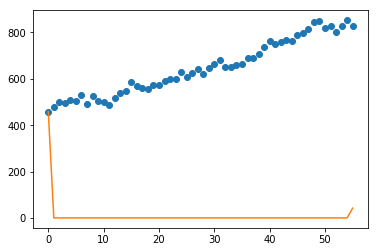

In [149]:
plt.plot(a_pars_pm_total/S_mem,'o')
plt.plot(fit_pars_total[0:len(time_pars)])

In [233]:
print v_interp

[[-6.86391   3.23452   1.74744  ..., -0.757586 -0.862093 -5.54212 ]
 [-6.86391   3.23452   1.74744  ..., -0.757586 -0.862093 -5.54212 ]
 [-6.86391   3.23452   1.74744  ..., -0.757586 -0.862093 -5.54212 ]
 ..., 
 [-6.86391   3.23452   1.74744  ..., -0.757586 -0.862093 -5.54212 ]
 [-6.86391   3.23452   1.74744  ..., -0.757586 -0.862093 -5.54212 ]
 [-6.86391   3.23452   1.74744  ..., -0.757586 -0.862093 -5.54212 ]]


In [253]:
np.max(abs(f_flow))

16.084

/home/moshir/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:80: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/home/moshir/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:805: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
/home/moshir/anaconda2/lib/python2.7/site-packages/matplotlib/rcsetup.py:155: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


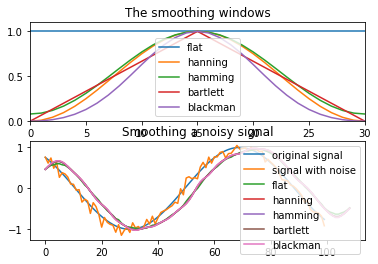

In [35]:
import numpy

def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError, "smooth only accepts 1 dimension arrays."

    if x.size < window_len:
        raise ValueError, "Input vector needs to be bigger than window size."


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError, "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'"


    s=numpy.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=numpy.ones(window_len,'d')
    else:
        w=eval('numpy.'+window+'(window_len)')

    y=numpy.convolve(w/w.sum(),s,mode='valid')
    return y




from numpy import *
from pylab import *

def smooth_demo():

    t=linspace(-4,4,100)
    x=sin(t)
    xn=x+randn(len(t))*0.1
    y=smooth(x)

    ws=31

    subplot(211)
    plot(ones(ws))

    windows=['flat', 'hanning', 'hamming', 'bartlett', 'blackman']

    hold(True)
    for w in windows[1:]:
        eval('plot('+w+'(ws) )')

    axis([0,30,0,1.1])

    legend(windows)
    title("The smoothing windows")
    subplot(212)
    plot(x)
    plot(xn)
    for w in windows:
        plot(smooth(xn,10,w))
    l=['original signal', 'signal with noise']
    l.extend(windows)

    legend(l)
    title("Smoothing a noisy signal")
    show()


if __name__=='__main__':
    smooth_demo()

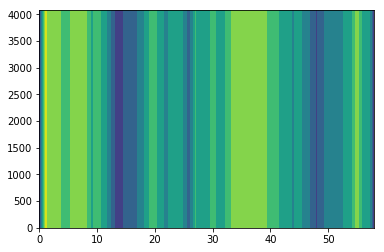

In [62]:
plt.contourf(v_interp)

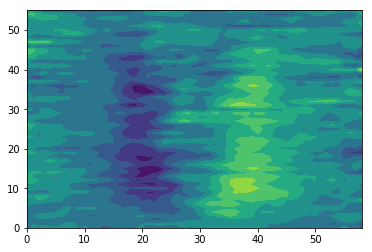

In [59]:
plt.contourf(f_flow)

$$  $$